In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/simjoo/Projects/10X_Skin/scripts/'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from Skin10X_misc_scripts_v1_4 import *
from Skin10X_plot_v1_0 import *
from Skin10X_affinity_propagation_v1_4 import *
from Skin10X_mann_whitney_u_v1_3 import *
from Skin10X_pseudotemporal_ordering_v1_3 import *

/Users/simjoo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import pickle
import velocyto as vcy

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client(profile='default')

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_Skin/scripts/")')
dview.execute('from Skin10X_affinity_propagation_v1_4 import *')
dview.execute('Skin10X_mann_whitney_u_v1_4 import *')

<AsyncResult: execute>

# Import Data

In [10]:
exp_id = '201806201840'
path_input = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/'
path_output = '/Users/simjoo/Projects/10X_Skin/data_output/v1.5'
path_figures = '/Users/simjoo/Projects/10X_Skin/figures/v1.5'

In [11]:
seq = loadData_v1(path_output, exp_id, 'seq', 'DataFrame')

In [12]:
seqN = loadData_v1(path_output, exp_id, 'seqN', 'DataFrame')

In [13]:
seqN_log2 = np.log2(seqN + 1)

In [14]:
cl_c_1st = loadData_v1(path_output, exp_id, 'cl_c_1st', 'Series')

In [15]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

In [16]:
cl_c_2nd = loadData_v1(path_output, exp_id, 'cl_c_2nd', 'Series')

In [17]:
cl_c_FIB = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'FIB']]
cl_c_FIB = AP_groups_reorder_v2(cl_c_FIB, ['FIB - 3', 'FIB - 4', 'FIB - 5', 'FIB - 6', 'FIB - 1', 'FIB - 2', 'FIB - 0'])

In [18]:
umap_FIB = loadData_v1(path_output, exp_id, 'umap_FIB', 'DataFrame')

In [19]:
MWU_av_FIB = loadData_v1(path_output, exp_id, 'MWU_av_FIB', 'DataFrame')

In [20]:
MWU_gr_FIB = loadData_v1(path_output, exp_id, 'MWU_gr_FIB', 'DataFrame')

In [21]:
cells_stage = pd.Series([c[-2:] for c in seq.columns], index = seq.columns)

In [22]:
cc_score_v2 = loadData_v1(path_output, exp_id, 'cc_score_v2','Series')

In [23]:
TF_mm9 = open('%s/TF_mm9.txt' % path_input, 'r').read().split()

In [24]:
bc = loadData_v1(path_input, exp_id, 'assigned_barcodes', 'Series')
cells_replicate = pd.Series(index = seq.columns)
for ix in cells_replicate.index:
    if type(bc['%s-1' % ix[:-3]]) != str:
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    elif bc['%s-1' % ix[:-3]] == 'unassigned':
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    else:
        cells_replicate[ix] = bc['%s-1' % ix[:-3]]

In [25]:
path = '%s/%s_cmap_1st.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_1st = pickle.load(f)

In [26]:
path = '%s/%s_cmap_2nd.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_2nd = pickle.load(f)

In [27]:
cmap_time = {'5w':'#fb9a99','9w':'#b2df8a'}

In [28]:
markers_time = {'5w':'o','9w':'o'}

# tSNE - cell selection

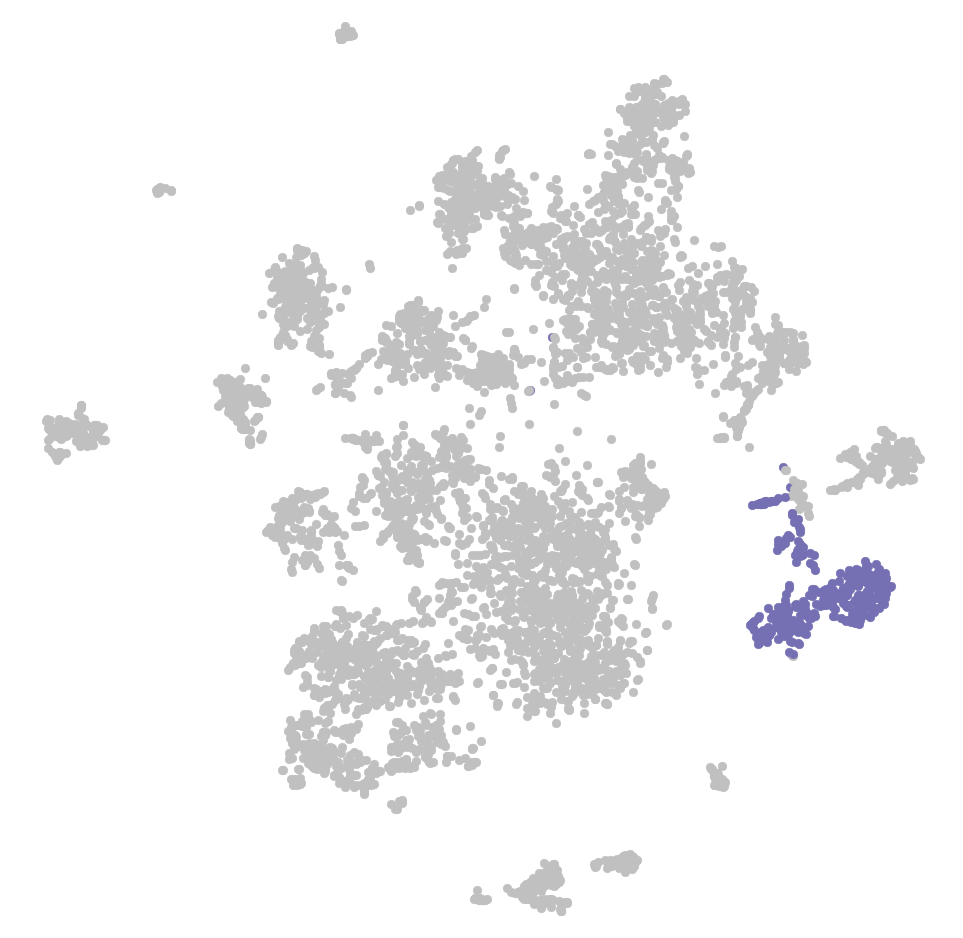

In [29]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'FIB':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['FIB'],
                    edgecolor=cmap_1st['FIB'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_tSNE_FIB_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - cell groups

In [30]:
Counter(cl_c_FIB)

Counter({'FIB - 3': 63,
         'FIB - 4': 77,
         'FIB - 5': 103,
         'FIB - 6': 71,
         'FIB - 1': 19,
         'FIB - 2': 21,
         'FIB - 0': 31})

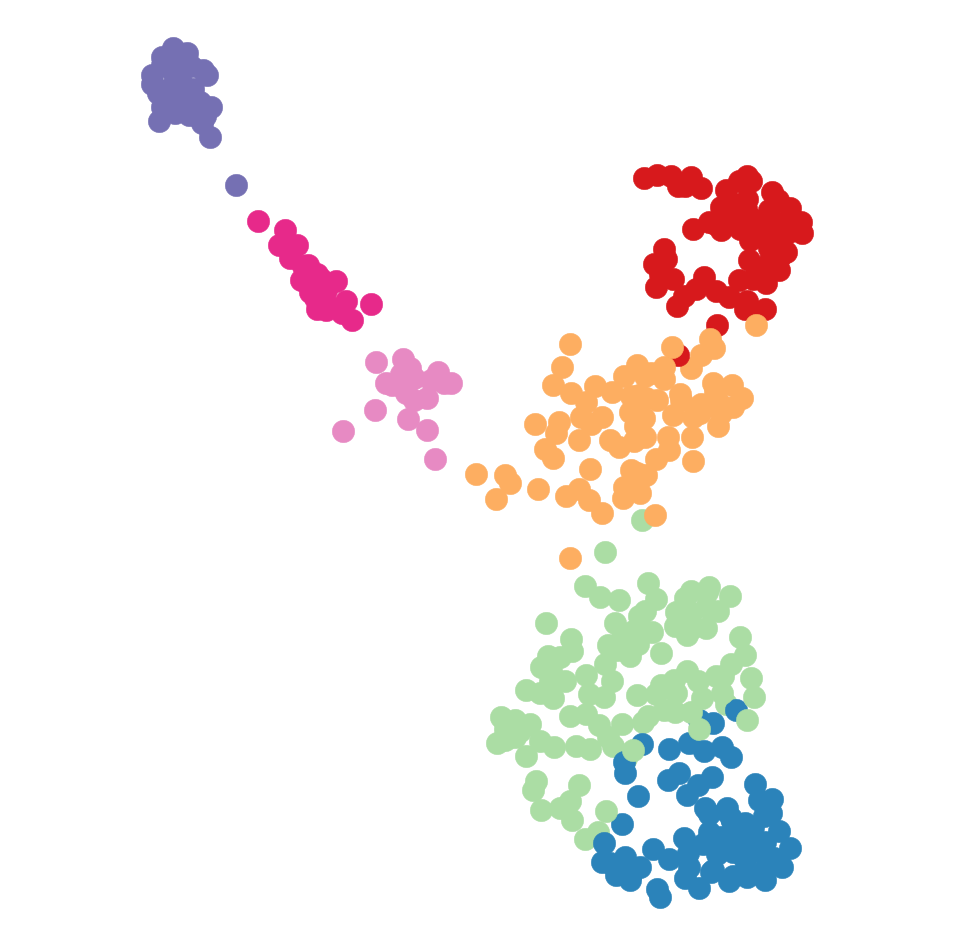

In [31]:
cells = cl_c_FIB
tsne = umap_FIB.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_tSNE_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - time points

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


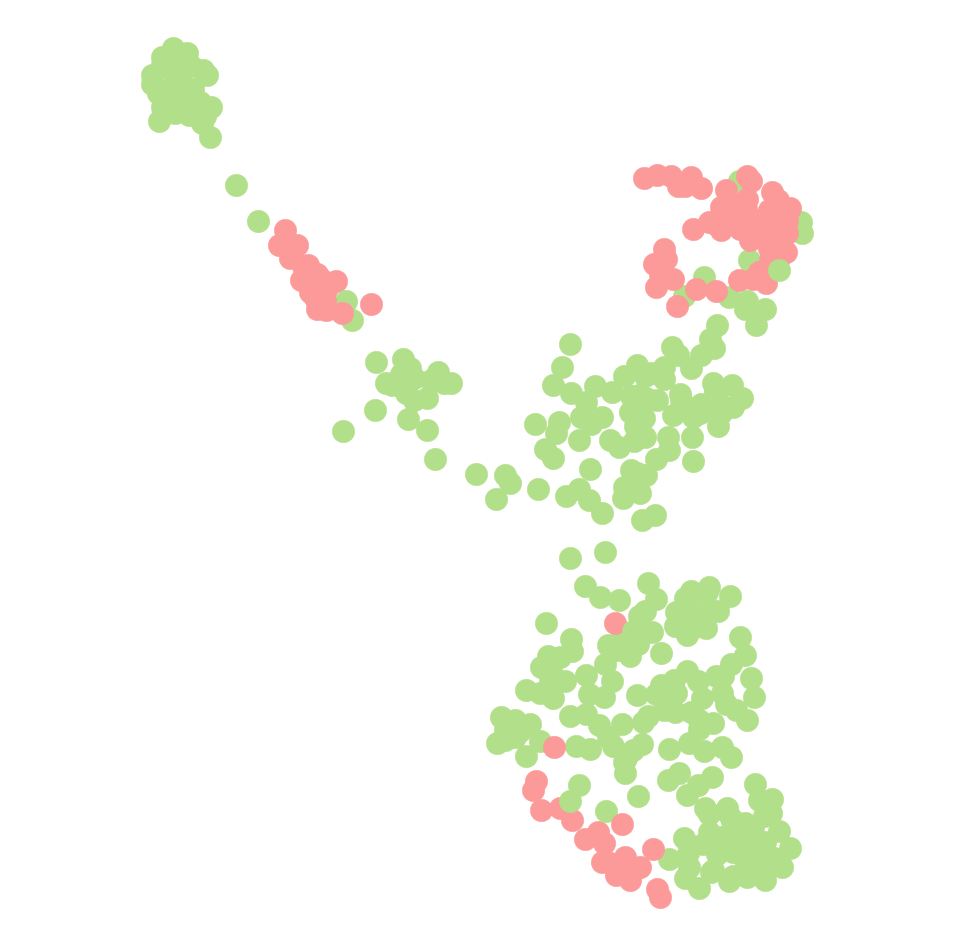

In [32]:
cells = cl_c_FIB
tsne = umap_FIB.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_tSNE_FIB_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - replicates

In [29]:
Counter(cells_replicate[cl_c_FIB.index])

Counter({'9wk2': 192,
         '5wk1': 36,
         '5wk2': 26,
         '9w unassigned': 28,
         '9wk1': 75,
         '5wk3': 27,
         '5w unassigned': 1})

In [32]:
cmap_replicate = {'9wk1':'#238b45',
                  '9wk2':'#74c476',
                  '9w unassigned':'#bae4b3',
                  '5wk1':'#cb181d',
                  '5wk2':'#fb6a4a',
                  '5wk3':'#fcae91',
                  '5w unassigned':'#fee5d9'}

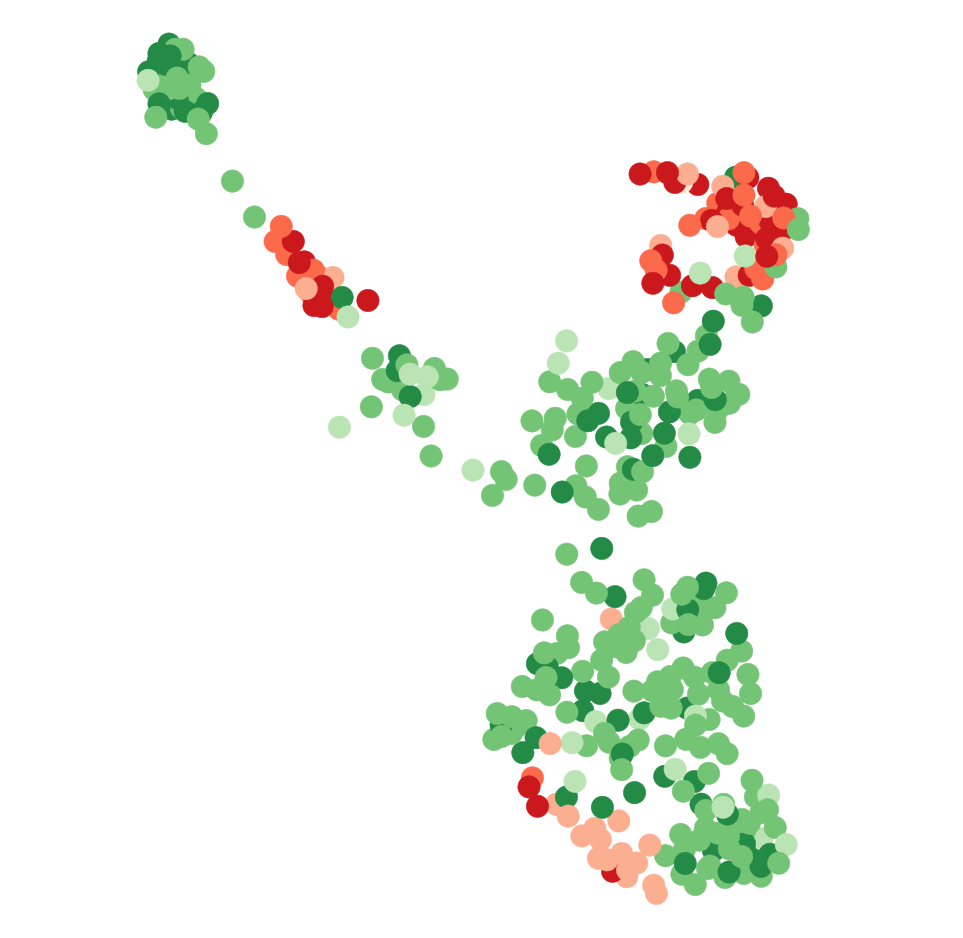

In [36]:
cells = cl_c_FIB
tsne = umap_FIB.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig2_tSNE_FIB_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

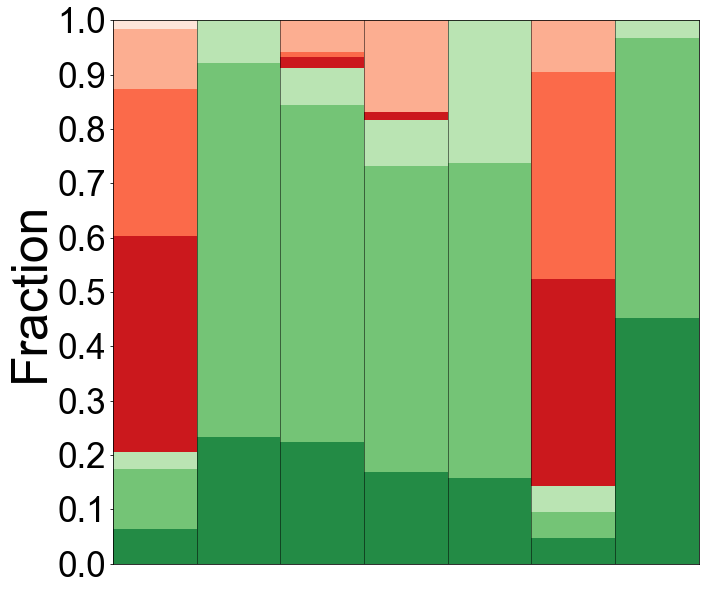

In [37]:
groups = cl_c_FIB
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig2_bar_FIB_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Barplots

In [198]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [205]:
genes = ['Col1a1','Sparc',
         'Dcn','Lum',
         'Cxcl12','Gpx3',
         'Mfap5','Plac8',
         'Ramp1','Enpp2',
         'Acta2','Corin',
         'Rasd1','Crabp1']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


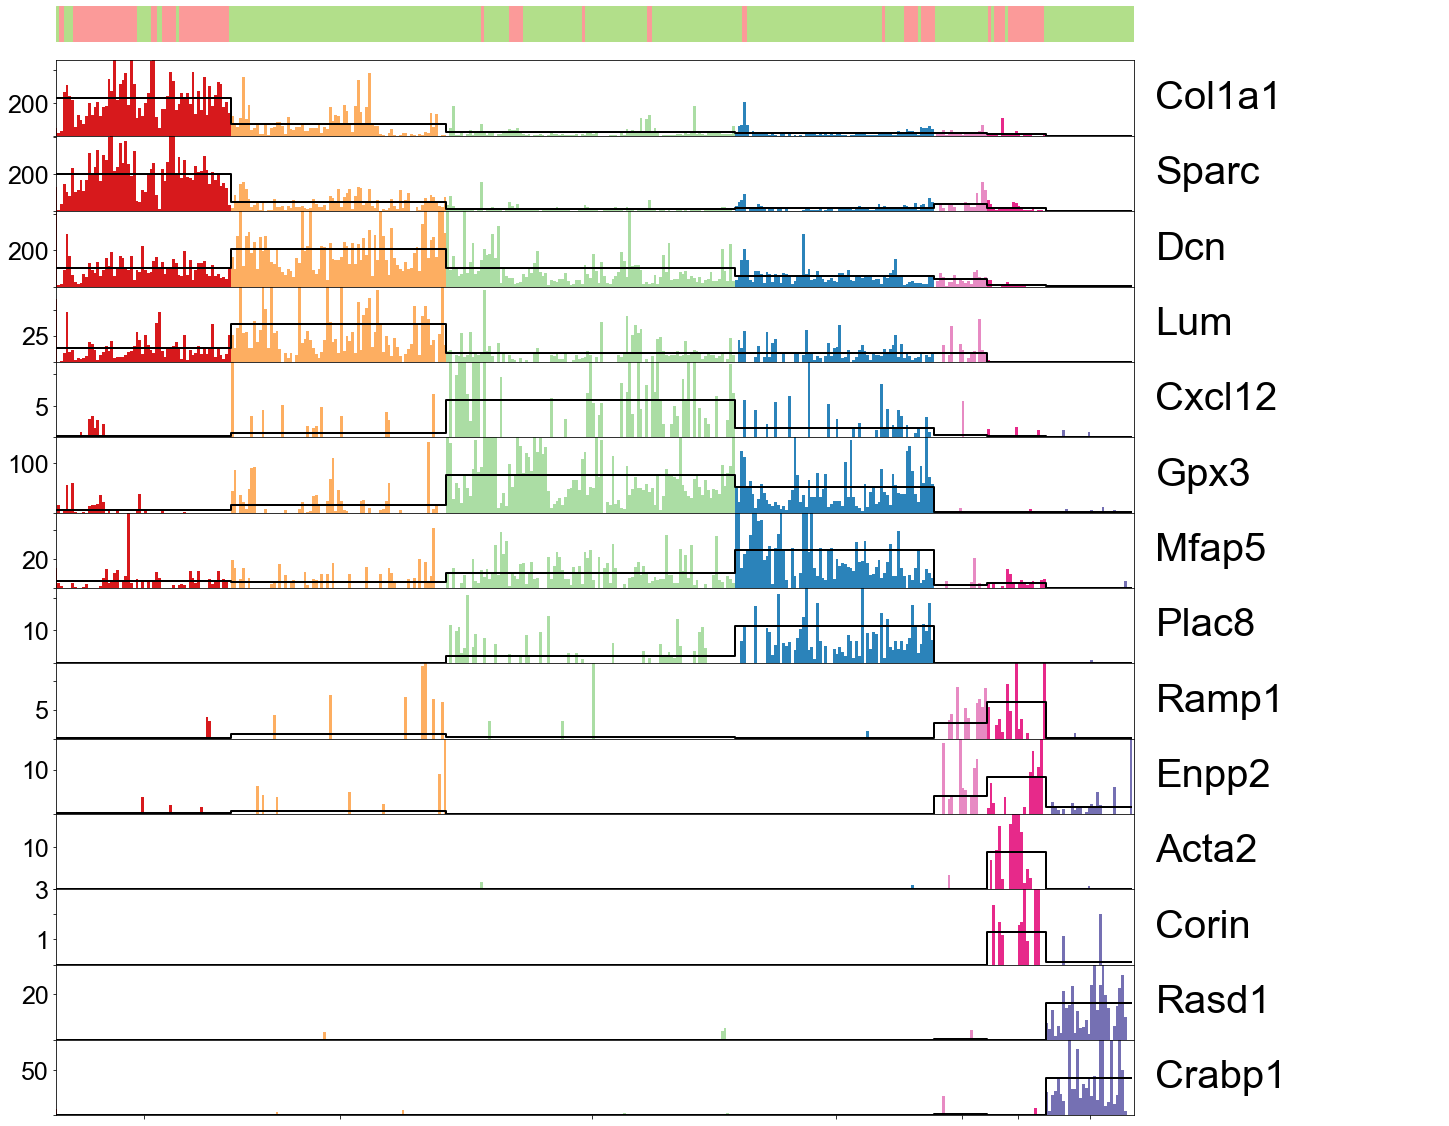

In [206]:
cell_groups = cl_c_FIB
dataset = seqN[cl_c_FIB.index]
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 20
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig5_bar_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell cycle stage

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


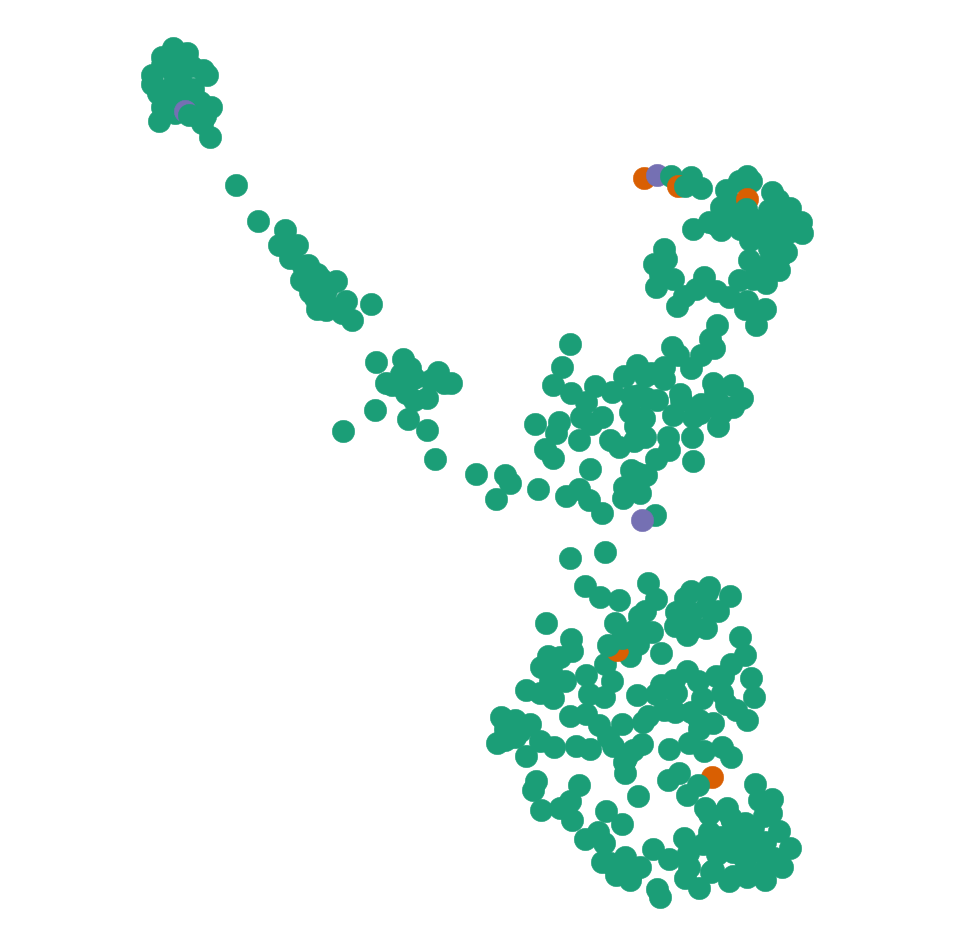

In [35]:
data = cc_score_v2.loc[cl_c_FIB.index]
cells = cl_c_FIB
tsne = umap_FIB.ix[cells.index]
cmap = {'G1':'#1b9e77','G2M':'#d95f02','S':'#7570b3'}
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[data[ix]],
                edgecolor=cmap[data[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_FIB_CC_class.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Fibroblast composition in anagen and telogen

In [111]:
c_sel_5w = cells_stage[cells_stage=='5w'].index
c_sel_9w = cells_stage[cells_stage=='9w'].index

In [123]:
cl_c_DF = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4','FIB - 5','FIB - 6',])]

In [131]:
cl_c_DF_5w = cl_c_DF[[c for c in c_sel_5w if c in cl_c_DF]]
cl_c_DF_9w = cl_c_DF[[c for c in c_sel_9w if c in cl_c_DF]]

In [132]:
Counter(cl_c_DF_5w)

Counter({'FIB - 3': 50, 'FIB - 5': 9, 'FIB - 6': 13})

In [133]:
Counter(cl_c_DF_9w)

Counter({'FIB - 6': 58, 'FIB - 5': 94, 'FIB - 3': 13, 'FIB - 4': 77})

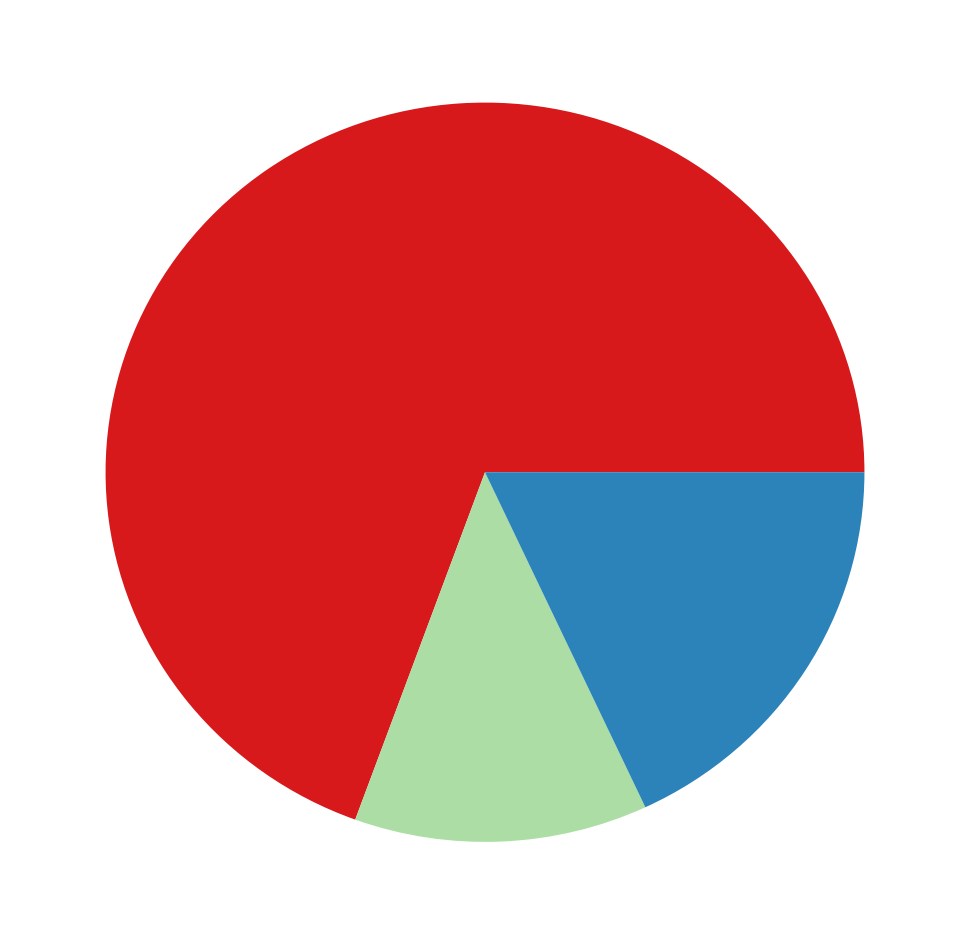

In [136]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (17,17))

#initialize data and colormap

pie_data1 = [Counter(cl_c_DF_5w)[gr] / len(cl_c_DF_5w) for gr in ['FIB - 3','FIB - 4','FIB - 5','FIB - 6',]]
pie_color1 = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']

#plot pie chart

ax0 = fig.add_subplot(111)
ax0.pie(pie_data1, colors = pie_color1, shadow = False)

figname = 'v1.5_Fig5_comp_5w.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)


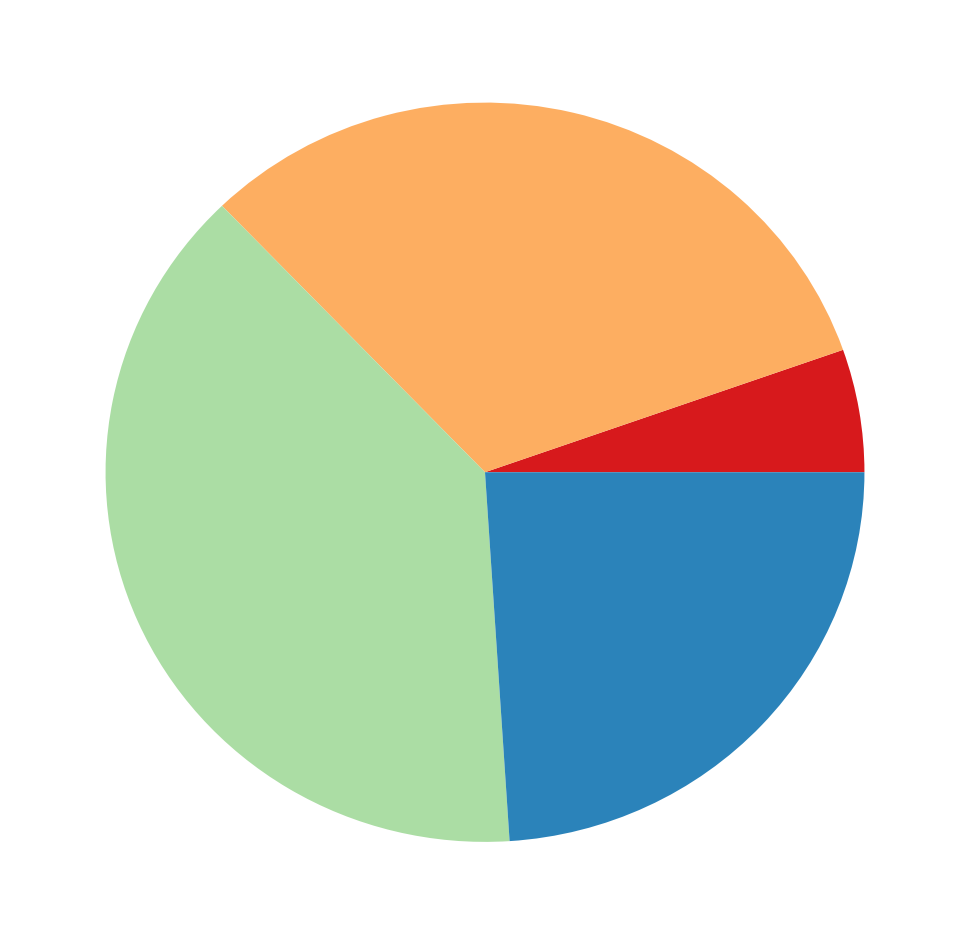

In [137]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (17,17))

#initialize data and colormap

pie_data1 = [Counter(cl_c_DF_9w)[gr] / len(cl_c_DF_9w) for gr in ['FIB - 3','FIB - 4','FIB - 5','FIB - 6',]]
pie_color1 = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']

#plot pie chart

ax0 = fig.add_subplot(111)
ax0.pie(pie_data1, colors = pie_color1, shadow = False)

figname = 'v1.5_Fig5_comp_9w.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)


# Marker gene expression

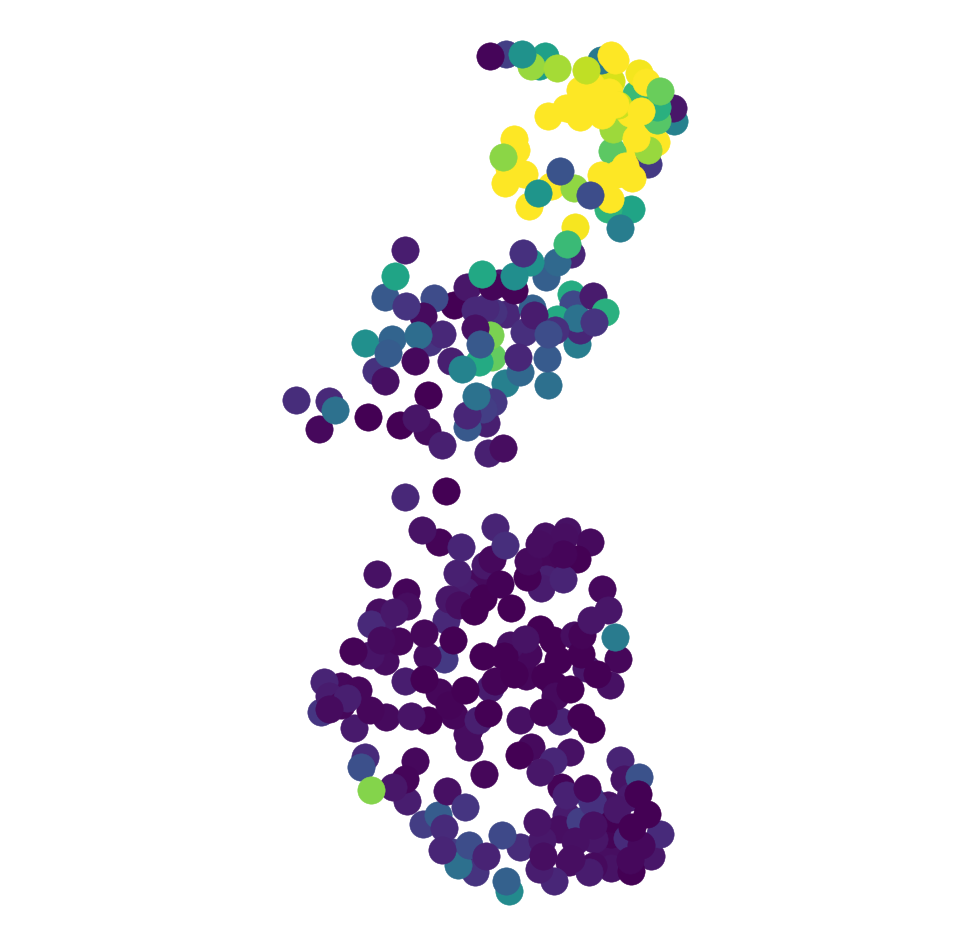

In [57]:
g = 'Sparc'

cells = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4','FIB - 5','FIB - 6'])]
tsne = umap_FIB.loc[cells.index]
expr = seqN.loc[g,cells.index]
vmin = np.percentile(expr, 10)
vmax = np.percentile(expr, 90)
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 750,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

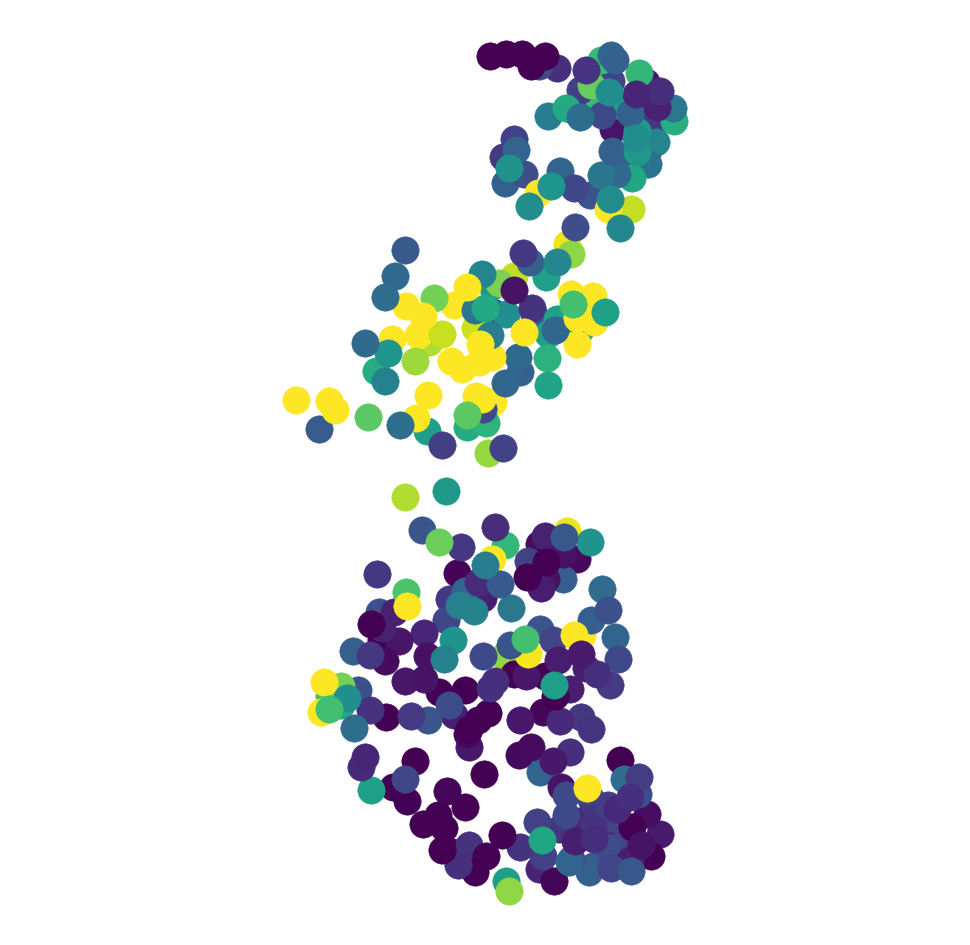

In [58]:
g = 'Dcn'

cells = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4','FIB - 5','FIB - 6'])]
tsne = umap_FIB.loc[cells.index]
expr = seqN.loc[g,cells.index]
vmin = np.percentile(expr, 10)
vmax = np.percentile(expr, 90)
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 750,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

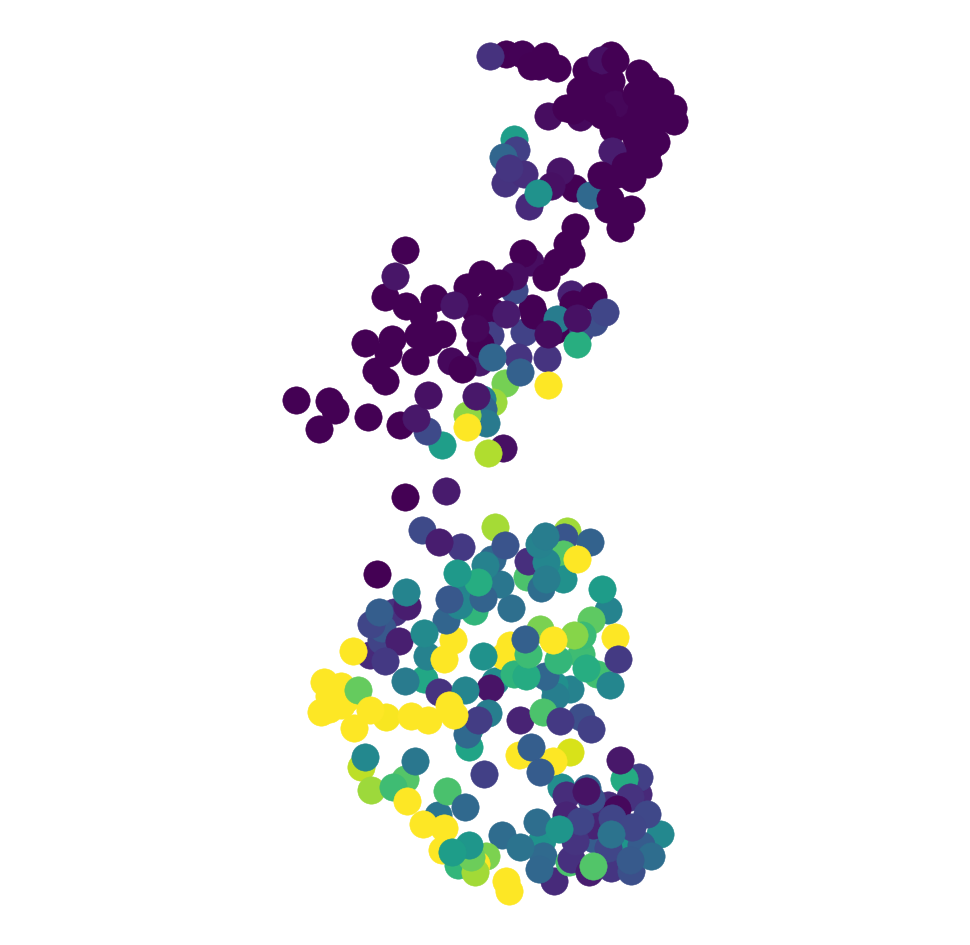

In [59]:
g = 'Gpx3'

cells = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4','FIB - 5','FIB - 6'])]
tsne = umap_FIB.loc[cells.index]
expr = seqN.loc[g,cells.index]
vmin = np.percentile(expr, 10)
vmax = np.percentile(expr, 90)
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 750,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

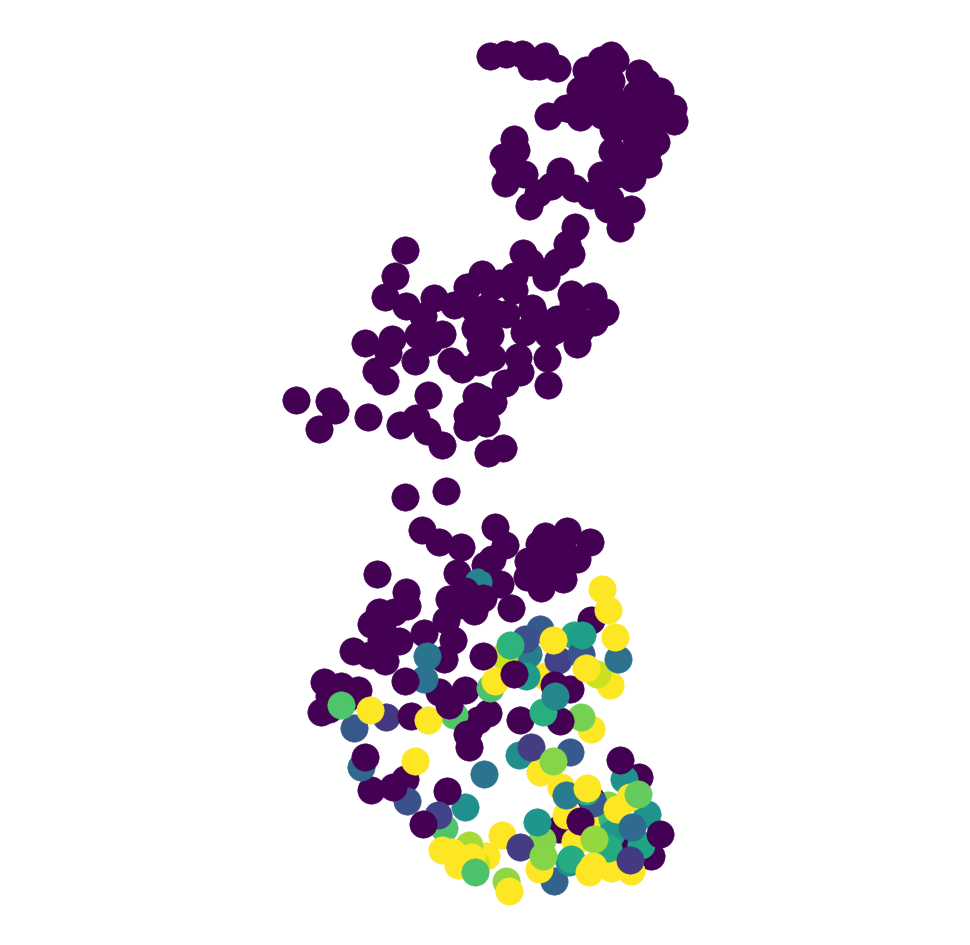

In [60]:
g = 'Plac8'

cells = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4','FIB - 5','FIB - 6'])]
tsne = umap_FIB.loc[cells.index]
expr = seqN.loc[g,cells.index]
vmin = np.percentile(expr, 10)
vmax = np.percentile(expr, 90)
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 750,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Difference between dermal fibroblast populations (#3, #4)

In [96]:
c_sel = cl_c_FIB[cl_c_FIB.isin(['FIB - 3','FIB - 4'])]

MWU_df = MWU_vs_average(seqN_log2, 
                        c_sel,
                        dropNull_v2X(seqN[c_sel.index], None, 0.1).index,
                        dview)


Dropping unexpressed genes from dataset


In [97]:
thr = -np.log10(0.05)

In [98]:
np.sum(MWU_df > thr)

FIB - 3    383
FIB - 4     41
dtype: int64

In [107]:
g_sel_3 = MWU_df['FIB - 3'][MWU_df['FIB - 3']>thr].index
g_sel_4 = MWU_df['FIB - 4'][MWU_df['FIB - 4']>thr].index

In [131]:
fc_df = pd.DataFrame(columns = ['FIB - 3','FIB - 4'], index = seqN.index)

fc_df['FIB - 3'] = seqN[cl_c_FIB[cl_c_FIB=='FIB - 3'].index].mean(axis=1)
fc_df['FIB - 4'] = seqN[cl_c_FIB[cl_c_FIB=='FIB - 4'].index].mean(axis=1)

fc_df = np.log2(fc_df['FIB - 3'] + 1) - np.log2(fc_df['FIB - 4'] + 1)

In [ ]:
Mfap4
Lum
Dcn

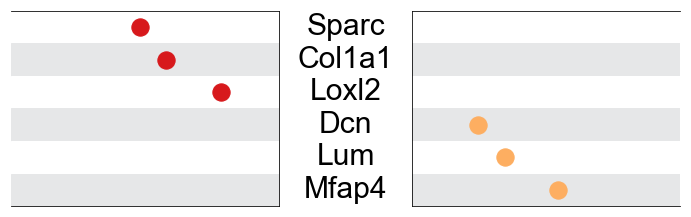

In [194]:
#define input variables

genes = ['Sparc','Col1a1','Loxl2','Dcn','Lum','Mfap4']
L = len(genes)
fc = fc_df
cmap = cmap_2nd

#initialize figure

height = L * 0.6
width = 12

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 3, hspace = 0.15, wspace = 0.0, width_ratios = [4,2,4])

#iterate through groups

#create gene name axis 
    
ax1 = plt.subplot(gs[0,1])
ax1.set_ylim(L - 0.5, -0.5)
clean_axis(ax1)

#create pval axes
    
ax0 = plt.subplot(gs[0,0])
ax0.spines['left'].set_color('none')
ax0.set_ylim(L - 0.5, -0.5)
ax0.yaxis.set_ticks_position('right')
ax0.yaxis.set_ticks([])

ax2 = plt.subplot(gs[0,2])
ax2.spines['right'].set_color('none')
ax2.set_ylim(L - 0.5, -0.5)
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks([])
   
#iterate over genes
    
for ix, g in enumerate(genes):
    ax1.text(0.5, ix, g, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
          
#print pvals

    if fc.loc[g] > 0:
        ax0.scatter(fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 3'])
        
    elif fc.loc[g] < 0:
        ax2.scatter(-fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 4'])
        
#set x-axis

ax0.set_xlim(4, 0)
ax0.set_xticks([])    
#for ix, t in enumerate(ax0.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)

ax2.set_xlim(0, 4)

ax2.set_xticks([])    
#for ix, t in enumerate(ax2.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)
        
figname = 'v1.5_Fig6_df_diff_ECM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

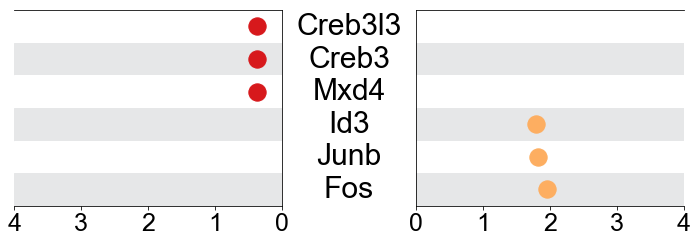

In [197]:
#define input variables

genes = ['Creb3l3','Creb3','Mxd4','Id3','Junb','Fos']
L = len(genes)
fc = fc_df
cmap = cmap_2nd

#initialize figure

height = L * 0.6
width = 12

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 3, hspace = 0.15, wspace = 0.0, width_ratios = [4,2,4])

#iterate through groups

#create gene name axis 
    
ax1 = plt.subplot(gs[0,1])
ax1.set_ylim(L - 0.5, -0.5)
clean_axis(ax1)

#create pval axes
    
ax0 = plt.subplot(gs[0,0])
ax0.spines['left'].set_color('none')
ax0.set_ylim(L - 0.5, -0.5)
ax0.yaxis.set_ticks_position('right')
ax0.yaxis.set_ticks([])

ax2 = plt.subplot(gs[0,2])
ax2.spines['right'].set_color('none')
ax2.set_ylim(L - 0.5, -0.5)
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks([])
   
#iterate over genes
    
for ix, g in enumerate(genes):
    ax1.text(0.5, ix, g, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
          
#print pvals

    if fc.loc[g] > 0:
        ax0.scatter(fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 3'])
        
    elif fc.loc[g] < 0:
        ax2.scatter(-fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 4'])
        
#set x-axis

ax0.set_xlim(4, 0)
ax0.set_xticks([0,1,2,3,4])
ax0.set_xticklabels([0,1,2,3,4], family = 'Arial', fontsize = 25)

ax2.set_xlim(0, 4)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels([0,1,2,3,4], family = 'Arial', fontsize = 25)
        
figname = 'v1.5_Fig6_df_diff_TF.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

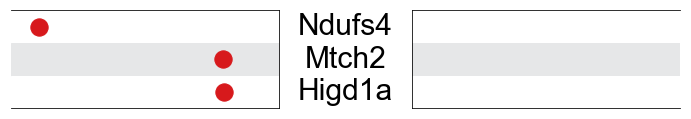

In [192]:
#define input variables

genes = ['Ndufs4','Mtch2','Higd1a']
L = len(genes)
fc = fc_df
cmap = cmap_2nd

#initialize figure

height = L * 0.6
width = 12

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 3, hspace = 0.15, wspace = 0.0, width_ratios = [4,2,4])

#iterate through groups

#create gene name axis 
    
ax1 = plt.subplot(gs[0,1])
ax1.set_ylim(L - 0.5, -0.5)
clean_axis(ax1)

#create pval axes
    
ax0 = plt.subplot(gs[0,0])
ax0.spines['left'].set_color('none')
ax0.set_ylim(L - 0.5, -0.5)
ax0.yaxis.set_ticks_position('right')
ax0.yaxis.set_ticks([])

ax2 = plt.subplot(gs[0,2])
ax2.spines['right'].set_color('none')
ax2.set_ylim(L - 0.5, -0.5)
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks([])
   
#iterate over genes
    
for ix, g in enumerate(genes):
    ax1.text(0.5, ix, g, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
          
#print pvals

    if fc.loc[g] > 0:
        ax0.scatter(fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 3'])
        
    elif fc.loc[g] < 0:
        ax2.scatter(-fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 4'])
        
#set x-axis

ax0.set_xlim(4, 0)
ax0.set_xticks([])    
#for ix, t in enumerate(ax0.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)

ax2.set_xlim(0, 4)

ax2.set_xticks([])    
#for ix, t in enumerate(ax2.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)
        
figname = 'v1.5_Fig6_df_diff_metabolism.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

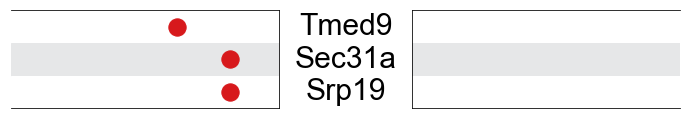

In [191]:
#define input variables

genes = ['Tmed9','Sec31a','Srp19']
L = len(genes)
fc = fc_df
cmap = cmap_2nd

#initialize figure

height = L * 0.6
width = 12

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 3, hspace = 0.15, wspace = 0.0, width_ratios = [4,2,4])

#iterate through groups

#create gene name axis 
    
ax1 = plt.subplot(gs[0,1])
ax1.set_ylim(L - 0.5, -0.5)
clean_axis(ax1)

#create pval axes
    
ax0 = plt.subplot(gs[0,0])
ax0.spines['left'].set_color('none')
ax0.set_ylim(L - 0.5, -0.5)
ax0.yaxis.set_ticks_position('right')
ax0.yaxis.set_ticks([])

ax2 = plt.subplot(gs[0,2])
ax2.spines['right'].set_color('none')
ax2.set_ylim(L - 0.5, -0.5)
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks([])
   
#iterate over genes
    
for ix, g in enumerate(genes):
    ax1.text(0.5, ix, g, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
          
#print pvals

    if fc.loc[g] > 0:
        ax0.scatter(fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 3'])
        
    elif fc.loc[g] < 0:
        ax2.scatter(-fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 4'])
        
#set x-axis

ax0.set_xlim(4, 0)
ax0.set_xticks([])    
#for ix, t in enumerate(ax0.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)

ax2.set_xlim(0, 4)

ax2.set_xticks([])    
#for ix, t in enumerate(ax2.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)
        
figname = 'v1.5_Fig6_df_diff_vesicle.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

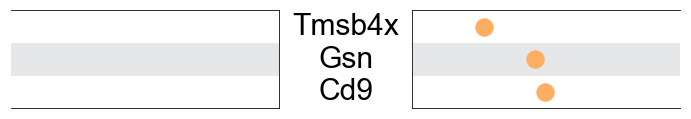

In [190]:
#define input variables

genes = ['Cd9','Gsn','Tmsb4x'][::-1]
L = len(genes)
fc = fc_df
cmap = cmap_2nd

#initialize figure

height = L * 0.6
width = 12

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 3, hspace = 0.15, wspace = 0.0, width_ratios = [4,2,4])

#iterate through groups

#create gene name axis 
    
ax1 = plt.subplot(gs[0,1])
ax1.set_ylim(L - 0.5, -0.5)
clean_axis(ax1)

#create pval axes
    
ax0 = plt.subplot(gs[0,0])
ax0.spines['left'].set_color('none')
ax0.set_ylim(L - 0.5, -0.5)
ax0.yaxis.set_ticks_position('right')
ax0.yaxis.set_ticks([])

ax2 = plt.subplot(gs[0,2])
ax2.spines['right'].set_color('none')
ax2.set_ylim(L - 0.5, -0.5)
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks([])
   
#iterate over genes
    
for ix, g in enumerate(genes):
    ax1.text(0.5, ix, g, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
        
    #print background
        
    if ix % 2 == 0:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax0.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax2.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
          
#print pvals

    if fc.loc[g] > 0:
        ax0.scatter(fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 3'])
        
    elif fc.loc[g] < 0:
        ax2.scatter(-fc.loc[g], ix, marker = 'o', s = 300, color = cmap['FIB - 4'])
        
#set x-axis

ax0.set_xlim(4, 0)
ax0.set_xticks([])    
#for ix, t in enumerate(ax0.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)

ax2.set_xlim(0, 4)

ax2.set_xticks([])    
#for ix, t in enumerate(ax2.xaxis.get_ticklabels()):
    #if ix % 2 == 0:
        #t.set_family('Arial')
        #t.set_fontsize(25)
    #else:
        #t.set_fontsize(0)
        
figname = 'v1.5_Fig6_df_diff_migration.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell-cell distance

In [150]:
seq_sel_FIB = loadData_v1(path_output, exp_id, 'seq_sel_FIB', 'DataFrame')

In [151]:
seq_sel_FIB_pca, dist_c_FIB = dim_reduc_pca(seq_sel_FIB, 15, 'euclidean', inverse_transform = False)

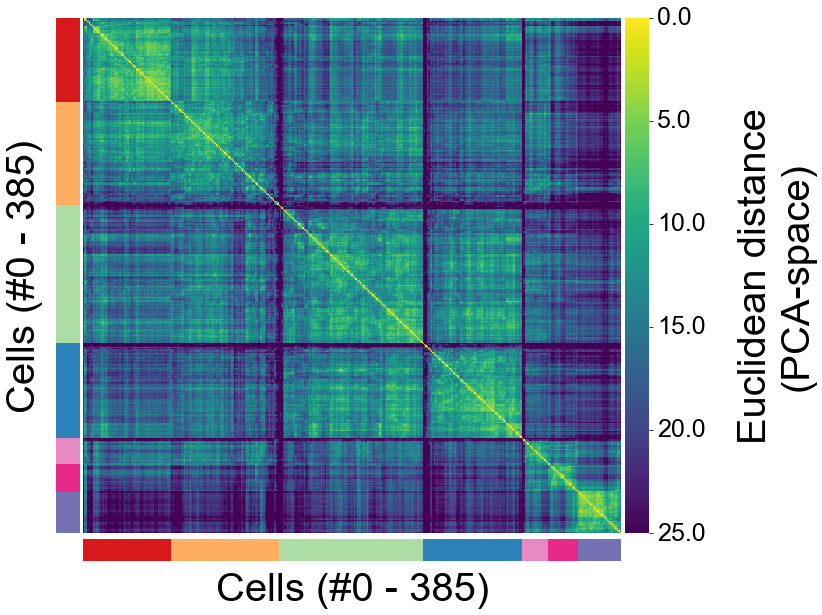

In [153]:
groups = cl_c_FIB
dist = dist_c_FIB
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS7_cell_cell_distance.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Differentially expressed genes

## Import scripts and data

In [385]:
def MWU_get_binarized(mwu_pval, cutoff, neglog = True):
    
    output = pd.DataFrame(index = mwu_pval.index, columns = mwu_pval.columns).fillna(0)
    
    if neglog == True:
        output[mwu_pval>=cutoff] = 1
    else:
        output[mwu_pval<cutoff] = 1
    
    return output

In [386]:
def MWU_extract_genes_(mwu_pval, mwu_bin, number = 10, neglog = True):
    
    output = pd.DataFrame(index = range(number), columns = mwu_bin.columns).fillna('None')
    
    for gr in mwu_bin.columns:
        g_bin = mwu_bin[gr][mwu_bin[gr]==1].index
        
        if neglog == True:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[-number:].index[::-1]
            #return g_sel
        else:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[number:].index
            
        output.loc[range(len(g_sel)), gr] = g_sel
        
    return output

In [156]:
MWU_av_FIB = loadData_v1(path_output, exp_id, 'MWU_av_FIB','DataFrame')
MWU_gr_FIB = loadData_v1(path_output, exp_id, 'MWU_gr_FIB','DataFrame')

## Compared to average

In [157]:
MWU_av_FIB[MWU_av_FIB==np.inf] = 307

In [158]:
MWU_av_FIB_bin = MWU_get_binarized(MWU_av_FIB, -np.log10(0.001), neglog = True)

In [159]:
MWU_av_FIB_genes = MWU_extract_genes_(MWU_av_FIB, MWU_av_FIB_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

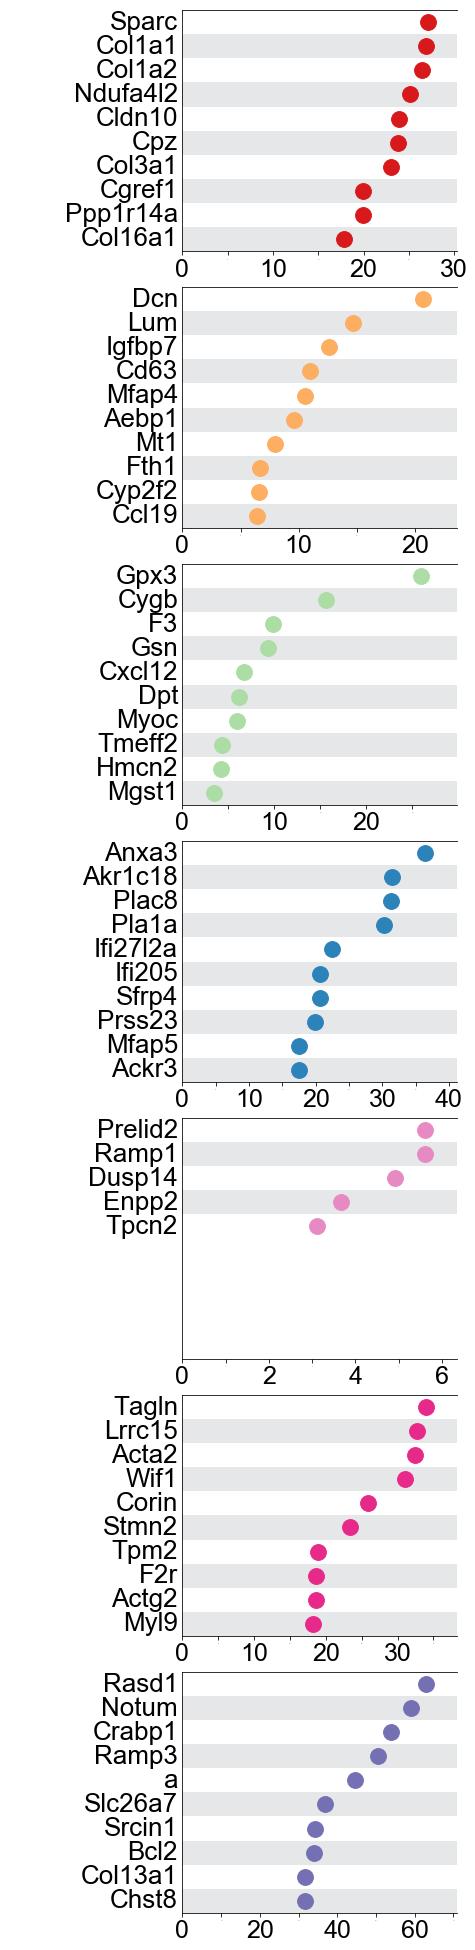

In [160]:
#define input variables

gr_order = return_unique(cl_c_FIB)
genes = MWU_av_FIB_genes
L = len(genes.index)
pval = MWU_av_FIB
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS7_MWU_vs_av_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Comparison to Seurat

In [32]:
cl_c_FIB_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_FIB_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [33]:
tsne_FIB_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_FIB_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_FIB_S.columns = ['x','y']

In [34]:
c_sel = list(set(cl_c_FIB_S.index) & set(cl_c_FIB.index))
cl_c_FIB_S = AP_groups_reorder_v2(cl_c_FIB_S[c_sel], [2,1,0,3])

In [35]:
cmap_FIB_S = {0:'#d7191c',
              2:'#2b83ba',
              1:'#abdda4',
              3:'#e7298a',
              4:'#7570b3'}

## tSNE

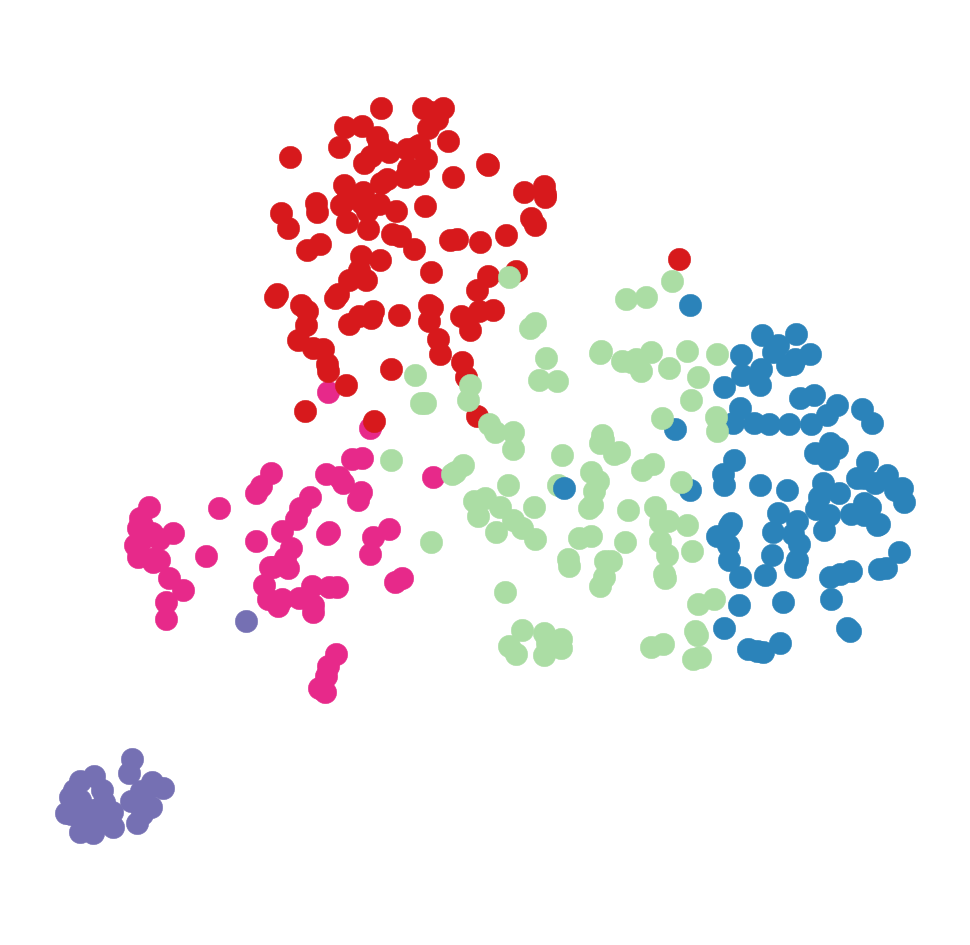

In [165]:
cells = cl_c_FIB_S
tsne = tsne_FIB_S.loc[cells.index]
cmap = cmap_FIB_S
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 500,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS7_tSNE_FIB_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Cell-cell-distance

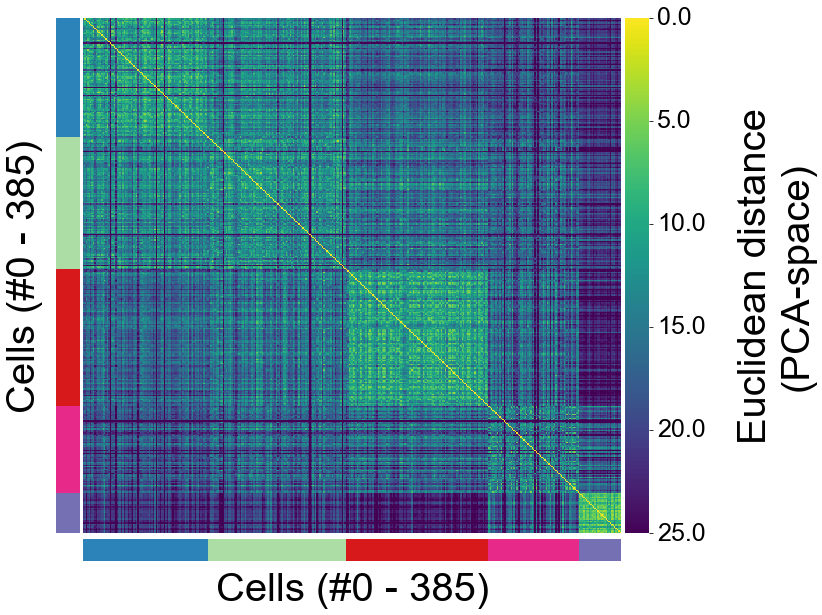

In [166]:
groups = cl_c_FIB_S
dist = dist_c_FIB
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_FIB_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS7_cell_cell_distance_FIB_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Comparison

In [167]:
def heatmap_diag(hm):
    
    import operator
    
    #get dict and sort
    
    d = {}
    
    for r in hm.index:
        for c in hm.columns:
            d[(r,c)] = hm.loc[r,c]
            
    r_sort, c_sort = [], []
            
    d = sorted(d.items(), key=operator.itemgetter(1), reverse = True)
    
    for i in d:
        if i[0][0] not in r_sort and i[0][1] not in c_sort:
            r_sort += [i[0][0]]
            c_sort += [i[0][1]]
    
    r_sort += [r for r in hm.index if r not in r_sort]
    c_sort += [c for c in hm.columns if c not in c_sort]
    
    return hm.loc[r_sort, c_sort]

In [168]:
def seurat_vs_AP(cl_ix, cl_col, return_counts = False):
    
    #define output
    
    output_perc = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    output_count = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    
    for col in return_unique(cl_col):
        ix_col = set(cl_col[cl_col==col].index)
        
        for row in return_unique(cl_ix):
            ix_row = set(cl_ix[cl_ix==row].index)
            
            output_perc.loc[row, col] = float(len(ix_row&ix_col)) / float(len(ix_row))
            output_count.loc[row, col] = float(len(ix_row&ix_col))
    
    if return_counts == True:
        return heatmap_diag(output_perc), output_count
    else:    
        return heatmap_diag(output)

In [169]:
seurat_vs_AP_FIB_perc, seurat_vs_AP_FIB_count = seurat_vs_AP(cl_c_FIB, cl_c_FIB_S, True)

In [36]:
from sklearn.metrics import adjusted_rand_score as rand

In [37]:
rand_FIB = rand(cl_c_FIB, cl_c_FIB_S)

In [38]:
rand_FIB

0.524971363596194

In [172]:
ix_sel = ['FIB - 1','FIB - 2','FIB - 3','FIB - 4','FIB - 0','FIB - 6']

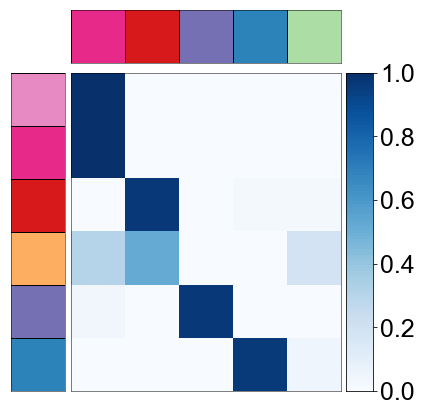

In [173]:
data = seurat_vs_AP_FIB_perc.loc[ix_sel]

cmap_ix = cmap_2nd
cmap_col = cmap_FIB_S

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS7_seurat_AP_comp_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# DS / DP subclustering (taken from validation dataset analysis)

In [30]:
X = sc.read_h5ad('%s/%s_X_MKnew_2nd_FIB_DPDS.h5' % (path_output, exp_id))
Xs = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_FIB_DPDS.h5' % (path_output, exp_id))

In [31]:
umap_DPDS_pd = pd.DataFrame(Xs.obsm['X_umap'], index = Xs.obs_names, columns = [0,1])

In [32]:
cmap_FIB_DPDS = {
            'FIB - tDP':'#7570b3',
            'FIB - DS1':'#e78ac3',
            'FIB - DS2':'#e7298a',
            'FIB - aDP':'#8e0152',}

## Clusters

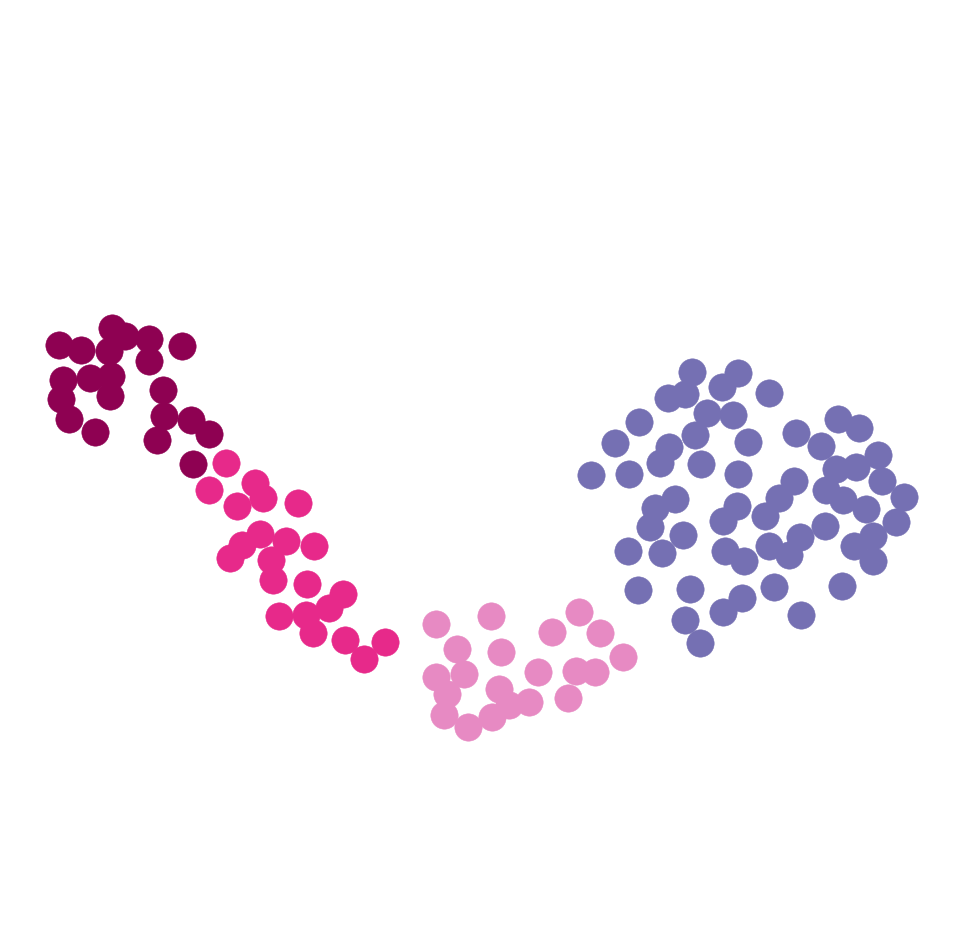

In [377]:
cells = Xs.obs['cl_2nd_FIB_DPDS']
tsne = umap_DPDS_pd
cmap = cmap_FIB_DPDS

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,0],
                tsne.loc[ix,1], 
                s = 750,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_tSNE_FIB_DPDS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

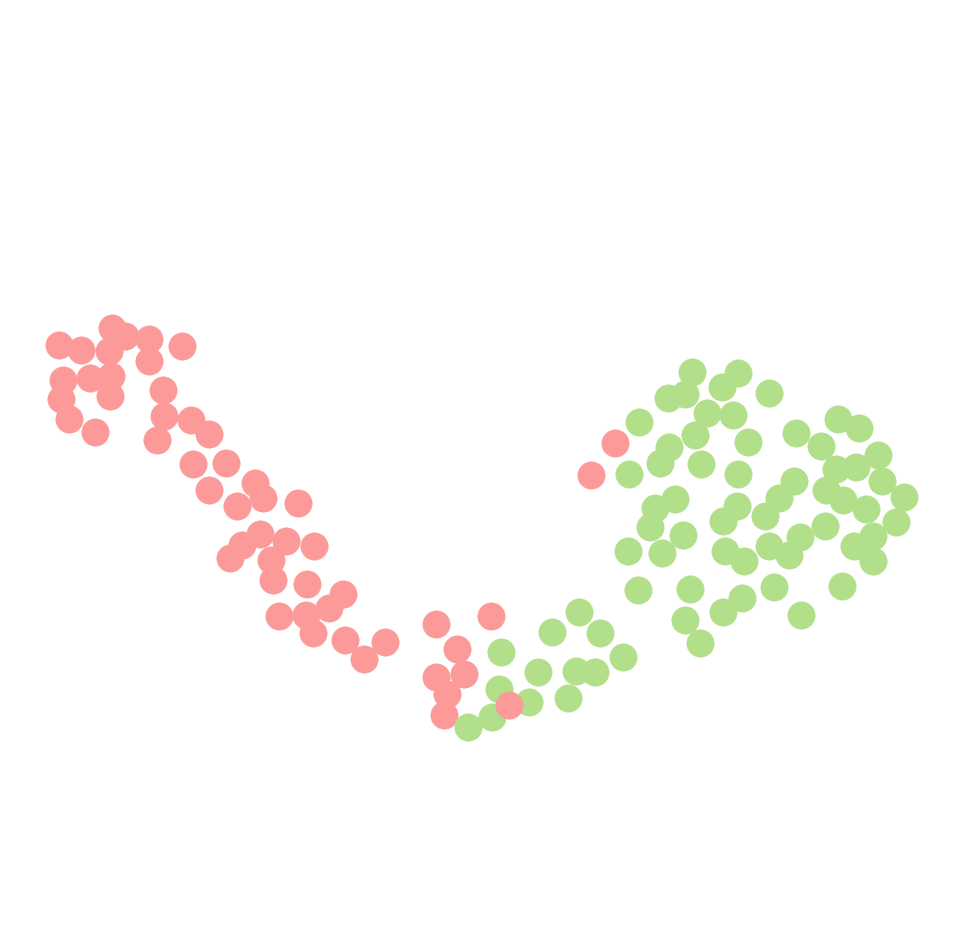

In [108]:
cells = Xs.obs['stage']
tsne = umap_DPDS_pd
cmap = {'anagen':'#fb9a99','telogen':'#b2df8a'}

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,0],
                tsne.loc[ix,1], 
                s = 750,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig5_tSNE_FIB_DPDS_stage.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Barplots

In [378]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [109]:
cl_c_DSDP = Xs.obs['cl_2nd_FIB_DPDS']

In [380]:
genes = ['Abi3bp','Ramp1','Mylk',
         'Acta2','Tagln','Grem2',
         'Corin','Nrg2','Cntn1',
         'Crabp1','Notum','Pappa2',]

In [193]:
genes = ['Ramp1','Mylk',
         'Acta2','Tagln',
         'Corin','Nrg2',
         'Crabp1','Notum']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


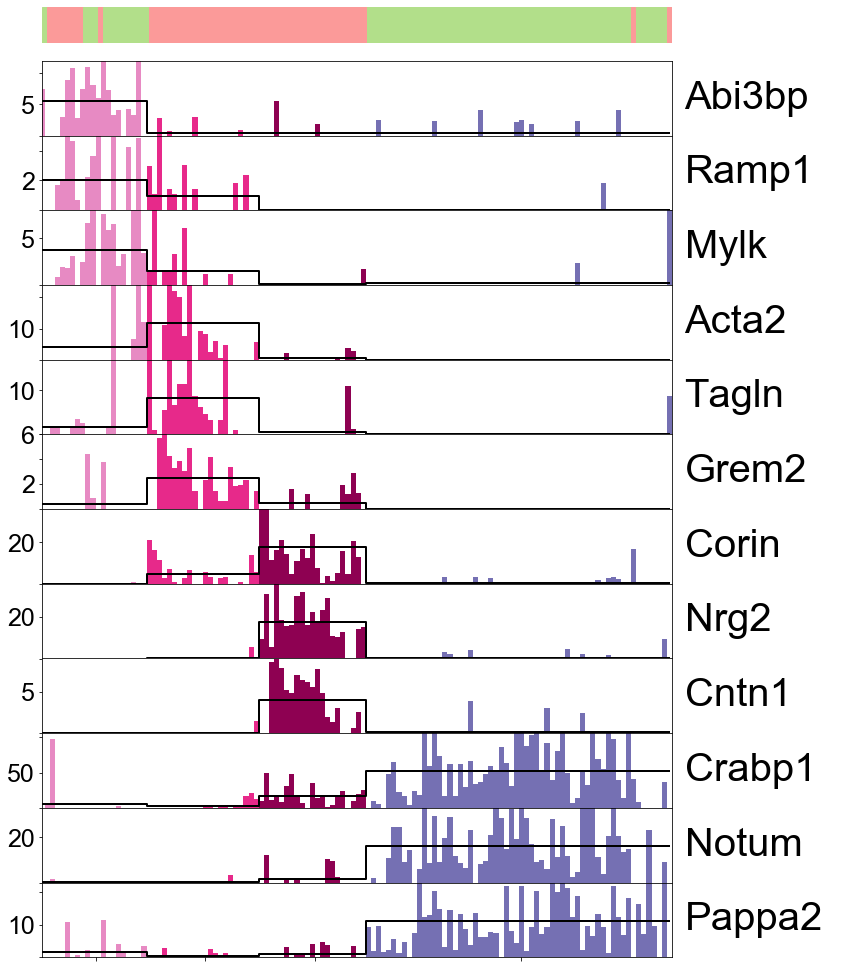

In [381]:
cell_groups = cl_c_DSDP
dataset = sc2pd(X, 'norm')[cell_groups.index]
#genes = ['Dkk2','Igfbp3','Pappa2']
cmap = cmap_FIB_DPDS
cells_stage = Xs.obs['stage'][cell_groups.index]
cmap_time = {'telogen': '#b2df8a', 'anagen': '#fb9a99'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 12
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns))-0.5)
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig5_bar_FIB_DPDS_v2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Differentially expressed genes

In [382]:
MWU_av_FIB_DPDS = loadData_v1(path_output, exp_id, 'MWU_av_FIB_DPDS','DataFrame')
MWU_gr_FIB_DPDS = loadData_v1(path_output, exp_id, 'MWU_gr_FIB_DPDS','DataFrame')

In [383]:
MWU_av_FIB_DPDS[MWU_av_FIB_DPDS==np.inf] = 307

In [387]:
MWU_av_FIB_DPDS_bin = MWU_get_binarized(MWU_av_FIB_DPDS, -np.log10(0.001), neglog = True)

In [388]:
MWU_av_FIB_DPDS_genes = MWU_extract_genes_(MWU_av_FIB_DPDS, MWU_av_FIB_DPDS_bin, number = 10, neglog = True)

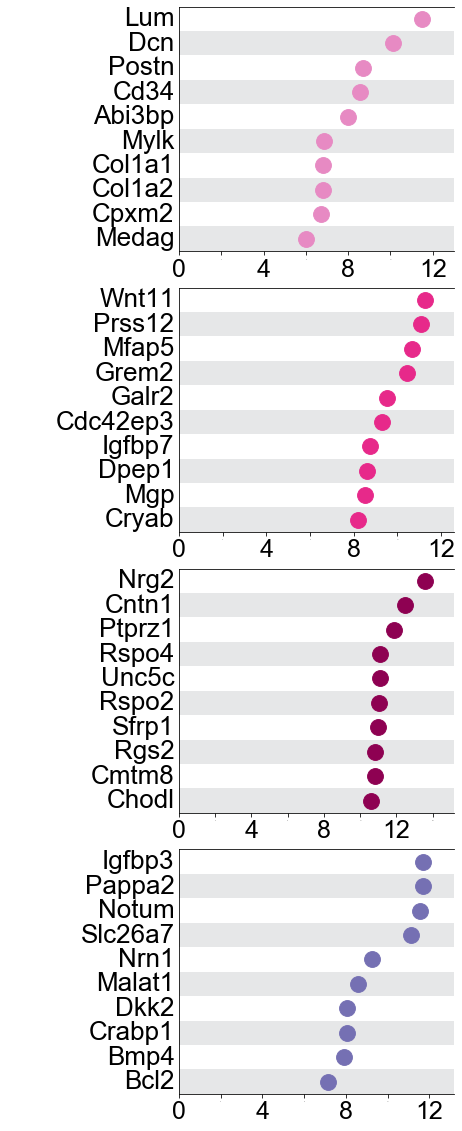

In [389]:
#define input variables

gr_order = return_unique(cl_c_DSDP)
genes = MWU_av_FIB_DPDS_genes
L = len(genes.index)
pval = MWU_av_FIB_DPDS
cmap = cmap_FIB_DPDS

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS7_MWU_vs_av_FIB_DPDS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Comparison to Salzer paper

In [29]:
import csv

In [30]:
dir_5w = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/raw_5w/'

In [31]:
path_Salzer = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/Salzer/'

## Import data

In [32]:
Salzer_meta = pd.read_table('%s/GSE111136_metadata.txt' % path_Salzer, index_col = 0)

In [33]:
P1960 = pd.read_table('%s/GSE111136_counts.P1960.tsv' % path_Salzer, index_col = 0)
P1961 = pd.read_table('%s/GSE111136_counts.P1961.tsv' % path_Salzer, index_col = 0)
P1962 = pd.read_table('%s/GSE111136_counts.P1962.tsv' % path_Salzer, index_col = 0)
P1963 = pd.read_table('%s/GSE111136_counts.P1963.tsv' % path_Salzer, index_col = 0)
P1964 = pd.read_table('%s/GSE111136_counts.P1964.tsv' % path_Salzer, index_col = 0)
P2004 = pd.read_table('%s/GSE111136_counts.P2004.tsv' % path_Salzer, index_col = 0)
P2005 = pd.read_table('%s/GSE111136_counts.P2005.tsv' % path_Salzer, index_col = 0)
P2134 = pd.read_table('%s/GSE111136_counts.P2134.tsv' % path_Salzer, index_col = 0)
P2135 = pd.read_table('%s/GSE111136_counts.P2135.tsv' % path_Salzer, index_col = 0)
P2139 = pd.read_table('%s/GSE111136_counts.P2139.tsv' % path_Salzer, index_col = 0)
P2143 = pd.read_table('%s/GSE111136_counts.P2143.tsv' % path_Salzer, index_col = 0)

In [67]:
Salzer_seq = pd.concat([P1960,P1961,P1962,P1963,P1964,P2004,P2005,P2134,P2135,P2139,P2143], axis=1)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [69]:
Salzer_seq.index = [i.split('.')[0] for i in Salzer_seq.index]

In [70]:
gene_names_10x = {row[0]:row[1] for row in csv.reader(open(os.path.join(dir_5w, "genes.tsv")), delimiter="\t")}

In [71]:
ix_sel = [i for i in Salzer_seq.index if i in gene_names_10x.keys()]

In [72]:
len(ix_sel)

28478

In [73]:
Salzer_seq = Salzer_seq.loc[ix_sel]

In [74]:
Salzer_seq.index = [gene_names_10x[i] for i in Salzer_seq.index]

In [75]:
Salzer_seq = fuse_genes_v1(Salzer_seq)

## Checkpoint

In [76]:
#saveData_v1(Salzer_seq, path_output, exp_id, 'Salzer_seq')

In [34]:
Salzer_seq = loadData_v1(path_output, exp_id, 'Salzer_seq', 'DataFrame')

## Select young fibroblasts

In [36]:
c_sel = Salzer_meta.loc['Age'][Salzer_meta.loc['Age']=='age: young'].index

In [37]:
len(c_sel)

352

In [38]:
Salzer_seq = Salzer_seq[c_sel]

## Remove unexpressed genes

In [39]:
Salzer_seq = dropNull_v2X(Salzer_seq, 0)


Dropping unexpressed genes from dataset


## Normalize

In [40]:
scale = Salzer_seq.sum() / Salzer_seq.sum().median()

In [41]:
Salzer_seqN = Salzer_seq / scale

## Feature selection


Dropping unexpressed genes from dataset

After mean expression cutoff of 1, 11223 genes remain

After high variance feature selection, 2500 genes remain


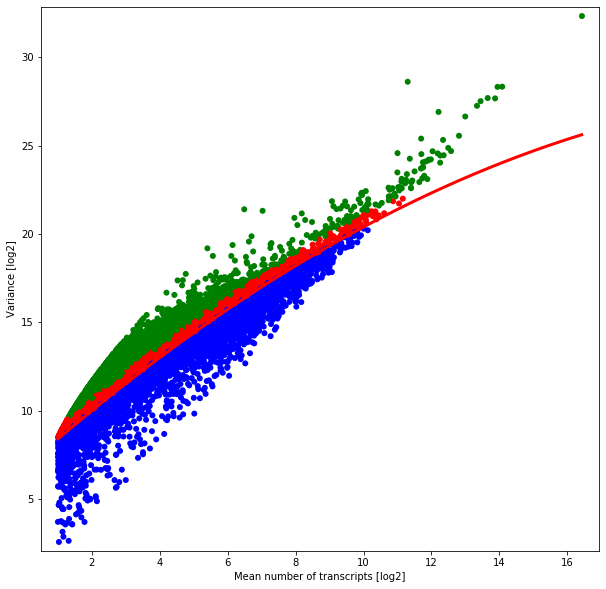

In [42]:
g_sel = select_features_log2_var_polyfit_v2(Salzer_seq, 1, 2500).index

In [43]:
Salzer_seqN_sel = Salzer_seqN.loc[g_sel]

## Remove cells with NaN

In [44]:
c_sel = Salzer_seqN_sel.isna().sum()[Salzer_seqN_sel.isna().sum()==0].index

In [45]:
len(c_sel)

350

In [46]:
Salzer_seqN = Salzer_seqN[c_sel]
Salzer_seqN_sel = Salzer_seqN_sel[c_sel]

## log transform

In [47]:
Salzer_seqN = np.log2(Salzer_seqN+1)
Salzer_seqN_sel = np.log2(Salzer_seqN_sel+1)

## Import to scanpy

In [48]:
X = to_scanpy(Salzer_seqN)

In [49]:
Xs = to_scanpy(Salzer_seqN_sel)

In [50]:
X.var_names = X.var['Gene']
Xs.var_names = Xs.var['Gene']

In [51]:
X.obs_names = X.obs['CellID']
Xs.obs_names = Xs.obs['CellID']

## Dimensionality reduction with PCA

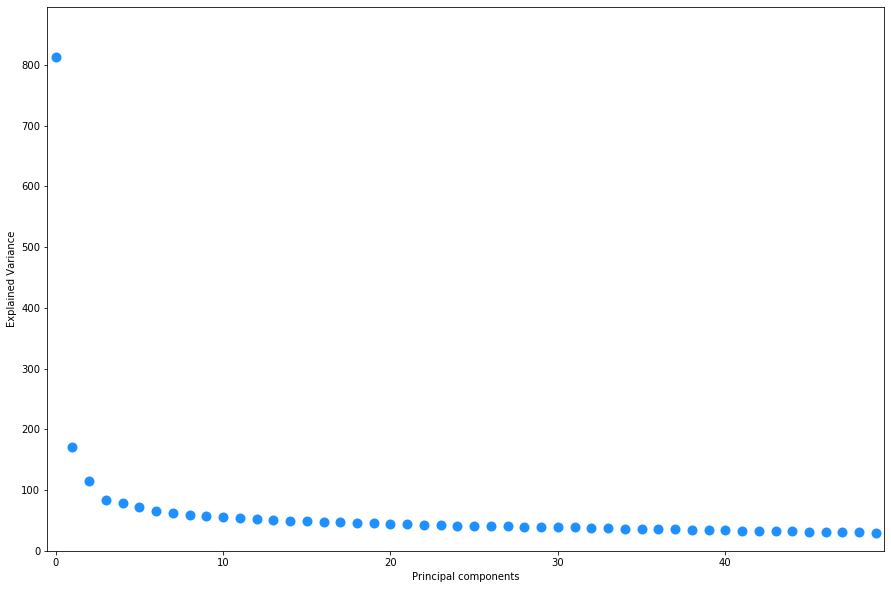

In [52]:
pca_explained_var(Salzer_seqN_sel)

In [53]:
sc.pp.pca(Xs, n_comps = 50)

## k nearest neighbors

In [54]:
sc.pp.neighbors(Xs, n_neighbors=30, n_pcs=5, metric='euclidean')

## UMAP

In [55]:
sc.tl.umap(Xs, min_dist=1, spread=2)

## Leiden clustering

In [57]:
sc.tl.leiden(Xs, resolution = 0.3)

In [58]:
len(set(Xs.obs['leiden']))

3

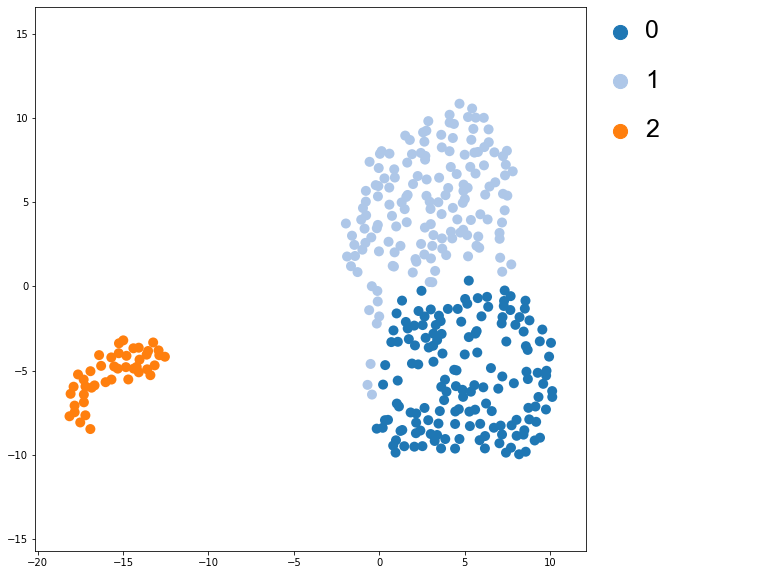

In [59]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['leiden'], 
                    s=100)

## Differential expression

In [248]:
genes_sel = dropNull_v2X(Salzer_seqN, None, 0.1).index


Dropping unexpressed genes from dataset


In [249]:
len(genes_sel)

9615

In [250]:
mwu_av_Salzer = MWU_vs_average(Salzer_seqN, Xs.obs['leiden'], genes_sel, dview)

## Cluster 2 is composed of low quality cells primarily defined by mitochondrial genes

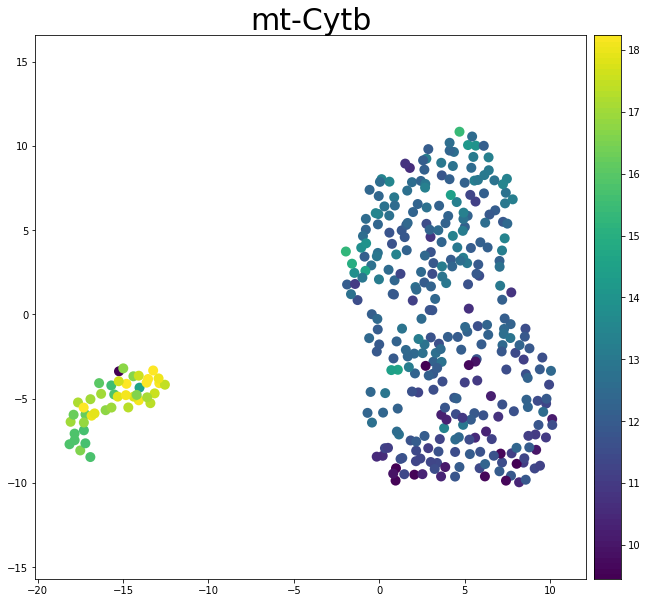

In [60]:
g = 'mt-Cytb'
expr = X[:,g].X
draw_scatter_expr(Xs.obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 100)

In [64]:
c_sel = Xs.obs['leiden'][Xs.obs['leiden']!='2'].index

In [65]:
len(c_sel)

306

In [66]:
X = X[c_sel]
Xs = Xs[c_sel]

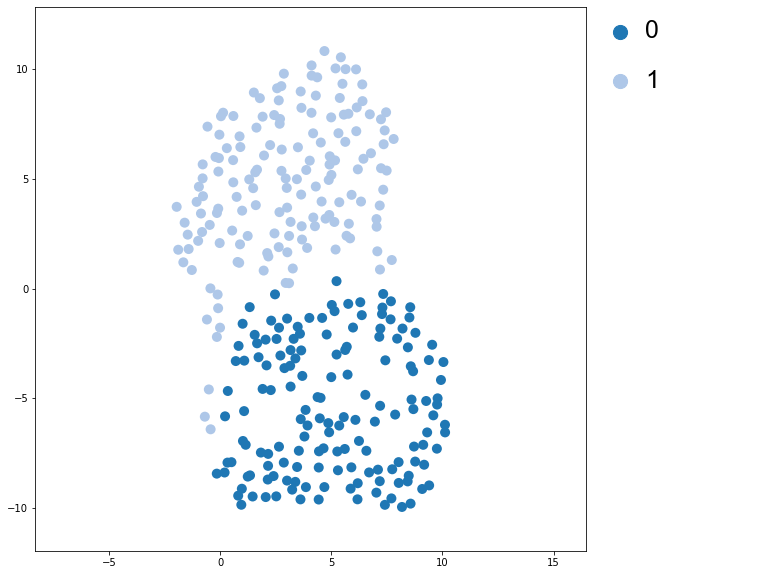

In [67]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['leiden'], 
                    s=100)

## Checkpoint

In [68]:
#X.write_h5ad('%s/%s_X_Salzer.h5' % (path_output, exp_id))
#Xs.write_h5ad('%s/%s_Xs_Salzer.h5' % (path_output, exp_id))

In [114]:
X = sc.read_h5ad('%s/%s_X_Salzer.h5' % (path_output, exp_id))
Xs = sc.read_h5ad('%s/%s_Xs_Salzer.h5' % (path_output, exp_id))

## Marker genes

In [115]:
umap_Salzer_pd = pd.DataFrame(Xs.obsm['X_umap'], index = Xs.obs_names, columns = [0,1])

In [116]:
X.layers['matrix'] = scipy.sparse.csr_matrix(X.X)

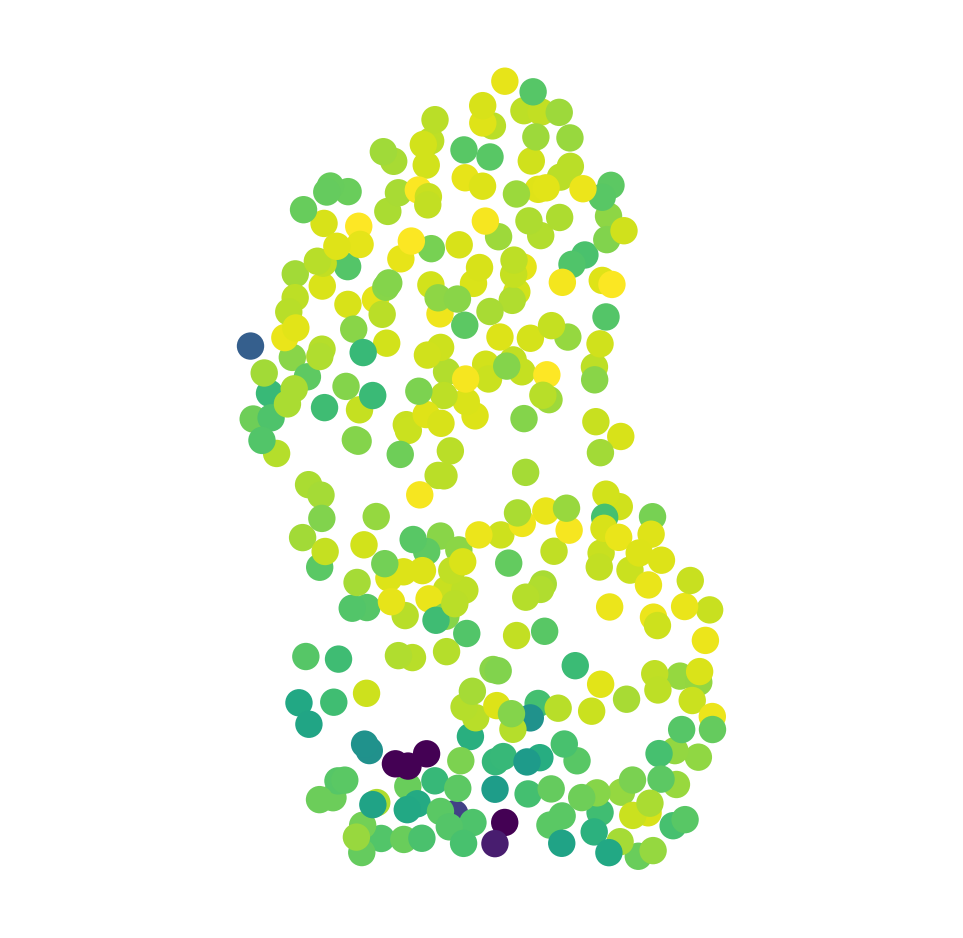

In [122]:
gene = 'Sparc'
expr = sc2pd(X, 'matrix').loc[gene]
coords = umap_Salzer_pd
vmin = 0
vmax = 15
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 750,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_Salzer_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

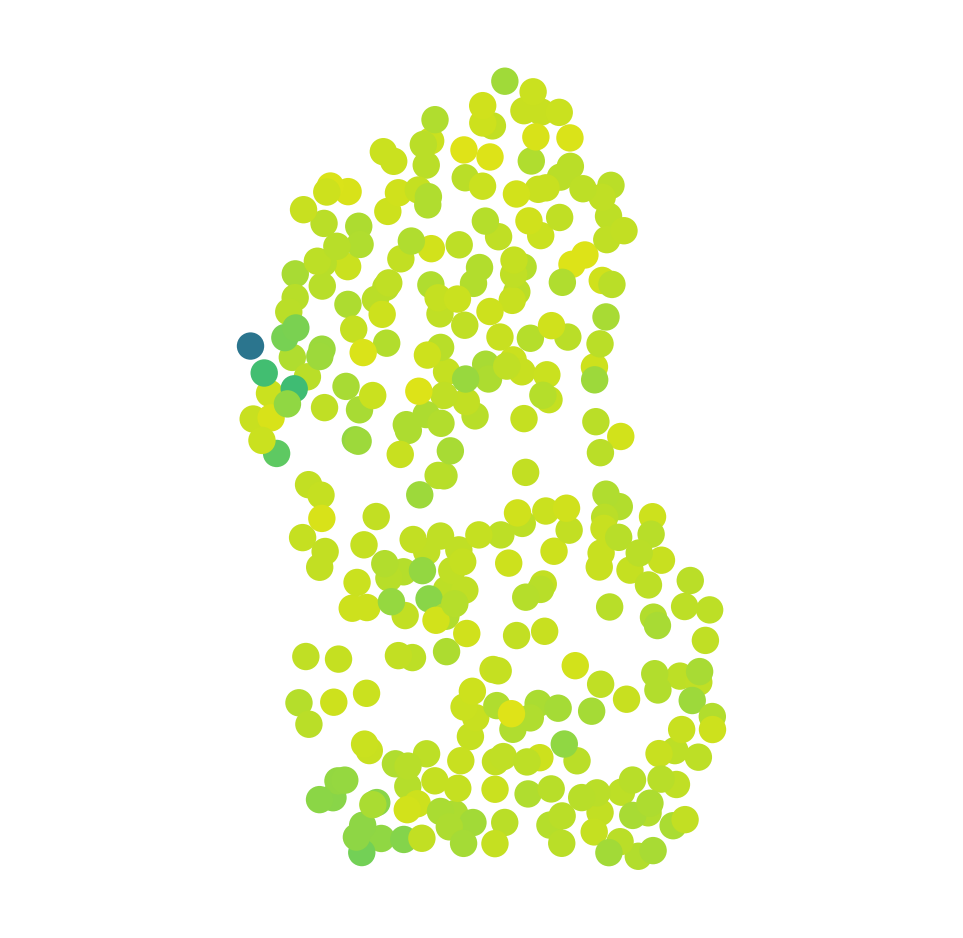

In [123]:
gene = 'Dcn'
expr = sc2pd(X, 'matrix').loc[gene]
coords = umap_Salzer_pd
vmin = 0
vmax = 18
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 750,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_Salzer_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

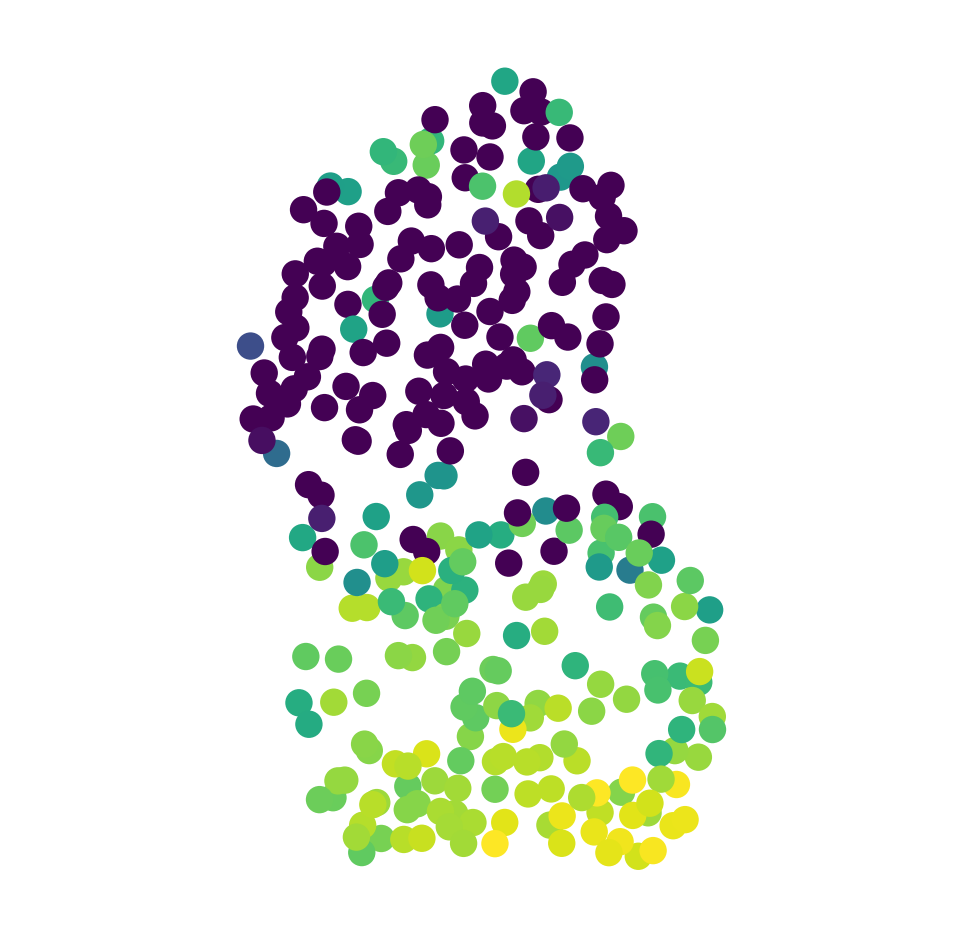

In [124]:
gene = 'Gpx3'
expr = sc2pd(X, 'matrix').loc[gene]
coords = umap_Salzer_pd
vmin = 0
vmax = 15
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 750,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_Salzer_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

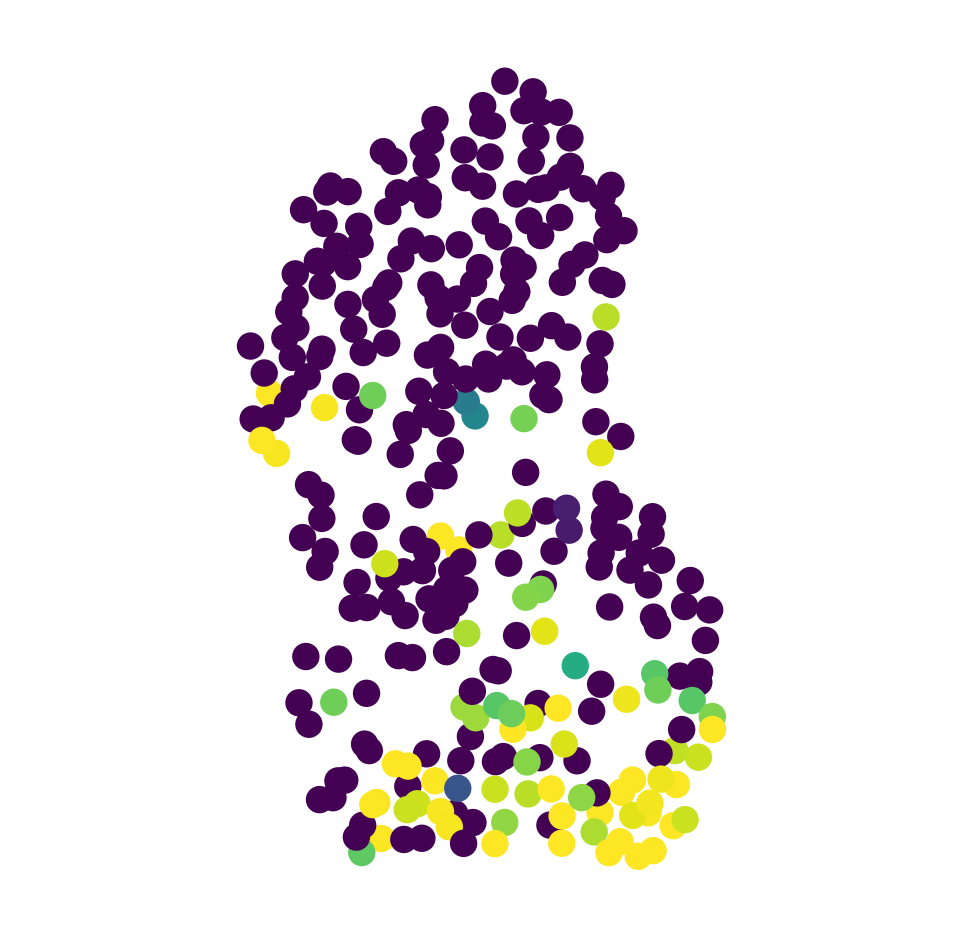

In [125]:
gene = 'Cxcl12'
expr = sc2pd(X, 'matrix').loc[gene]
coords = umap_Salzer_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 750,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_Salzer_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

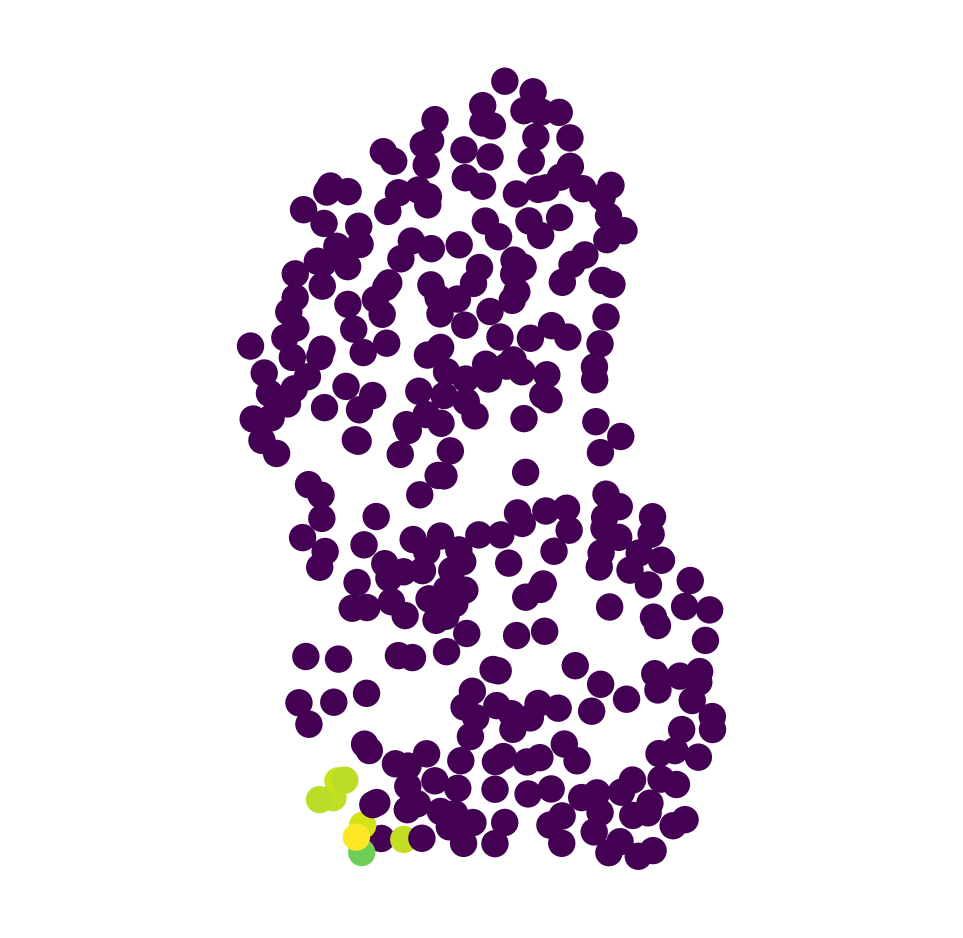

In [126]:
gene = 'Plac8'
expr = sc2pd(X, 'matrix').loc[gene]
coords = umap_Salzer_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 750,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_Salzer_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)